In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk import pos_tag,sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import ttest_ind

# Download NLTK data (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Download NLTK data (if not already downloaded)
nltk.download('punkt',quiet=True)
nltk.download('averaged_perceptron_tagger',quiet=True)
nltk.download('vader_lexicon',quiet=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('clickbait_data.csv')
train_data.rename(columns={'clickbait':'label'},inplace=True)
train_data

headline  label
0                                     Should I Get Bings      1
1          Which TV Female Friend Group Do You Belong In      1
2      The New "Star Wars: The Force Awakens" Trailer...      1
3      This Vine Of New York On "Celebrity Big Brothe...      1
4      A Couple Did A Stunning Photo Shoot With Their...      1
...                                                  ...    ...
31995  To Make Female Hearts Flutter in Iraq, Throw a...      0
31996  British Liberal Democrat Patsy Calton, 56, die...      0
31997  Drone smartphone app to help heart attack vict...      0
31998  Netanyahu Urges Pope Benedict, in Israel, to D...      0
31999  Computer Makers Prepare to Stake Bigger Claim ...      0

[32000 rows x 2 columns]

In [3]:
def extract_linguistic_features(headline):
    features = {}
    
    # Tokenize the text
    words = word_tokenize(headline)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    # Check for sensational language
    sensational_language = any(word in filtered_words for word in ['shocking','amazing', 'unbelievable', 'breaking','exclusive','scandalous','revelation','controversial','blockbuster','sensational','unprecedented','outrageous','heartwarming','crucial','insider'])                                           
    features['sensational_language'] = sensational_language

    # Check for numbers or lists
    contains_numbers = any(char.isdigit() for word in filtered_words for char in word)
    features['contains_numbers'] = contains_numbers

    # Check for personal pronouns
    contains_personal_pronouns = any(word.lower() in ['you', 'your'] for word in words)
    features['contains_personal_pronouns'] = contains_personal_pronouns

    # Check for celebrity involvement
    celebrity_involvement = any(word in filtered_words for word in ['celebrity', 'star', 'famous'])
    features['celebrity_involvement'] = celebrity_involvement

    # Check for misleading information
    misleading_information = 'change your life' in headline.lower()
    features['misleading_information'] = misleading_information
 
    # Feature: Length of the headline
    features['length'] = len(headline)

    # Feature: Presence of exclamation marks
    features['has_exclamation'] = '!' in headline

    # Feature: Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(headline)
    features['sentiment'] = sentiment_scores['compound']

    # Feature: Presence of question marks
    features['has_question'] = '?' in headline

    # Feature: Presence of all caps
    features['all_caps'] = headline.isupper()

    return features

# Example usage:
features_array = []
clickbait_features = []
nonclickbait_features = []

clickbait_text = train_data[train_data['label']==1]['headline'].tolist()
nonclickbait_text = train_data[train_data['label']==0]['headline'].tolist()

for headline in train_data['headline']:
    features = extract_linguistic_features(headline)
    features_array.append(features)

df_all = pd.DataFrame(features_array)
df_all['label'] = train_data['label']

for headline in clickbait_text:
    features = extract_linguistic_features(headline)
    clickbait_features.append(features)
    
df_clickbait = pd.DataFrame(clickbait_features)
df_clickbait['label'] = 1
    
for headline in nonclickbait_text:
    features = extract_linguistic_features(headline)
    nonclickbait_features.append(features)

df_nonclickbait = pd.DataFrame(nonclickbait_features)
df_nonclickbait.reset_index(drop=True, inplace=True)
df_nonclickbait['label'] = 0

In [4]:
sentiment = df_all['sentiment'].values
contains_numbers = df_all['contains_numbers'].values
contains_personal_pronouns = df_all['contains_personal_pronouns'].values

In [5]:
# Summary Statistics
summary_stats = df_all.groupby('label').describe().transpose()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
label                       0             1
length    count  16001.000000  15999.000000
          mean      51.853322     55.741046
          std       14.357056     14.923931
          min       11.000000      6.000000
          25%       42.000000     46.000000
          50%       49.000000     56.000000
          75%       60.000000     65.000000
          max      135.000000    125.000000
sentiment count  16001.000000  15999.000000
          mean      -0.107141      0.106765
          std        0.381339      0.371855
          min       -0.948500     -0.927400
          25%       -0.401900      0.000000
          50%        0.000000      0.000000
          75%        0.000000      0.421500
          max        0.928700      0.941300


Summary statistics you provided are descriptive statistics for the features 'length' and 'sentiment' based on the labels (0 for non-clickbait, 1 for clickbait). Let's break down the information:

### Feature: Length
- **Count:** The number of data points for each label.
- **Mean:** The average length of headlines for each label. Clickbait headlines tend to be slightly longer on average (55.74) compared to non-clickbait headlines (51.85).
- **Standard Deviation (std):** A measure of the amount of variation or dispersion. Clickbait headlines have a slightly higher variation in length compared to non-clickbait headlines.
- **Min:** The minimum length of headlines. Clickbait headlines have a minimum length of 6, while non-clickbait headlines have a minimum length of 11.
- **25%, 50%, 75% (Percentiles):** These values indicate the data distribution. For example, the 75th percentile for clickbait headlines is 65, meaning that 75% of clickbait headlines have a length of 65 characters or less.
- **Max:** The maximum length of headlines. Clickbait headlines have a maximum length of 125, while non-clickbait headlines have a maximum length of 135.

### Feature: Sentiment
- **Count:** The number of data points for each label.
- **Mean:** The average sentiment score for each label. Clickbait headlines have a slightly positive average sentiment (0.1068), while non-clickbait headlines have a slightly negative average sentiment (-0.1071).
- **Standard Deviation (std):** The amount of variation in sentiment scores. Both clickbait and non-clickbait headlines show a similar level of variation in sentiment.
- **Min:** The minimum sentiment score. Clickbait headlines have a minimum sentiment score of -0.9274, while non-clickbait headlines have a minimum of -0.9485.
- **25%, 50%, 75% (Percentiles):** These values indicate the data distribution. For example, the 75th percentile for clickbait headlines is 0.4215, meaning that 75% of clickbait headlines have a sentiment score of 0.4215 or less.
- **Max:** The maximum sentiment score. Clickbait headlines have a maximum sentiment score of 0.9413, while non-clickbait headlines have a maximum of 0.9287.

Here are some conclusions you can draw from the provided summary statistics:

### Length Feature:
1. **Average Length:** Clickbait headlines tend to be slightly longer on average (55.74 characters) compared to non-clickbait headlines (51.85 characters).
  
2. **Variability:** Clickbait headlines have a slightly higher variability in length (as indicated by the standard deviation) compared to non-clickbait headlines. This suggests that the length of clickbait headlines varies more widely than non-clickbait headlines.

3. **Minimum and Maximum Length:** Clickbait headlines have a minimum length of 6 characters and a maximum length of 125 characters, while non-clickbait headlines have a minimum length of 11 characters and a maximum length of 135 characters. This indicates that there is a wide range of headline lengths for both categories.

### Sentiment Feature:
1. **Average Sentiment:** Clickbait headlines, on average, have a slightly positive sentiment (0.1068), while non-clickbait headlines have a slightly negative average sentiment (-0.1071).

2. **Similar Variability:** Both clickbait and non-clickbait headlines show a similar level of variability in sentiment scores, as indicated by the standard deviation.

3. **Minimum and Maximum Sentiment:** Clickbait headlines have a minimum sentiment score of -0.9274 and a maximum of 0.9413. Non-clickbait headlines have a minimum sentiment score of -0.9485 and a maximum of 0.9287. This indicates that sentiment scores for both categories cover a wide range, and there is no clear dominance of positive or negative sentiment in either category.

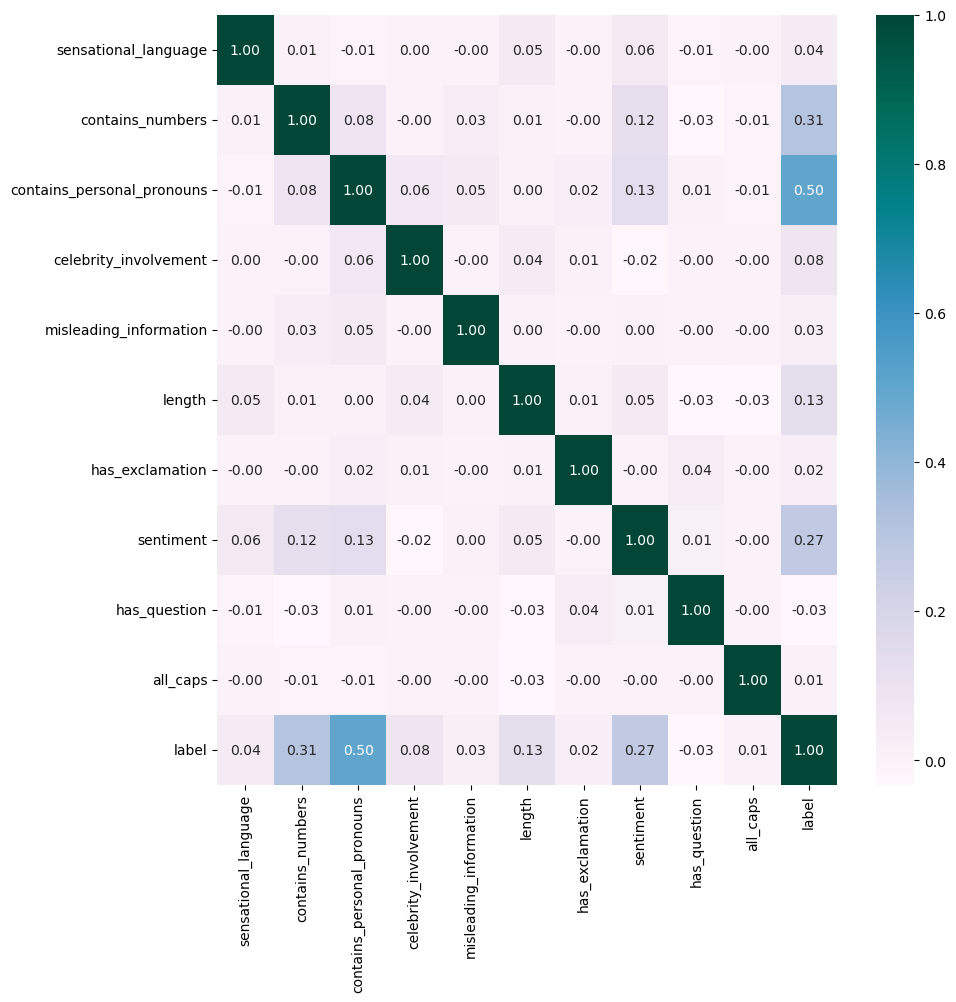

In [6]:
plt.figure(figsize=(10, 10))

sns.heatmap(df_all.corr(), annot=True, cmap='PuBuGn', fmt=".2f")
plt.show()

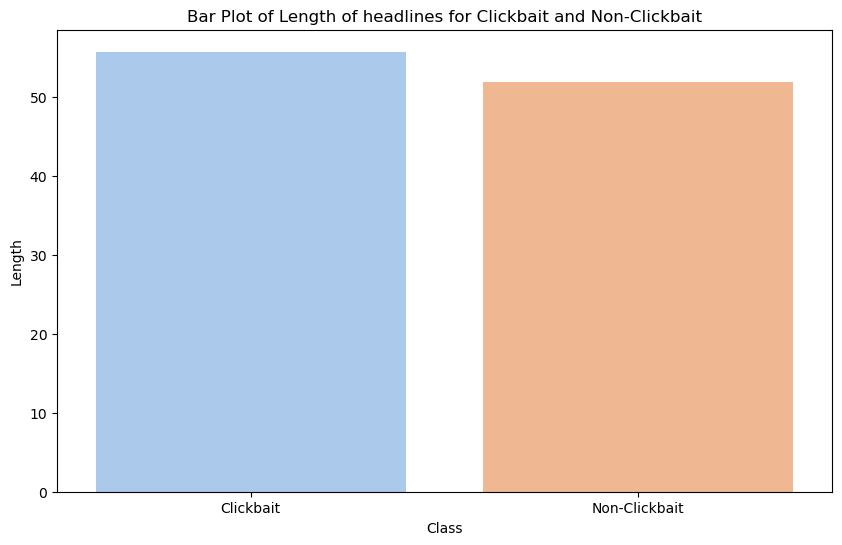

In [7]:
clickbait_lengths = df_clickbait['length']
nonclickbait_lengths = df_nonclickbait['length']

# Combine the data into a DataFrame for Seaborn
df = pd.DataFrame({
    'Class': ['Clickbait'] * len(clickbait_lengths) + ['Non-Clickbait'] * len(nonclickbait_lengths),
    'Length': clickbait_lengths.tolist() + nonclickbait_lengths.tolist()
})

# Create a box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Length', data=df, ci=None, palette='pastel')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Length')
plt.title('Bar Plot of Length of headlines for Clickbait and Non-Clickbait')

# Show the plot
plt.show()

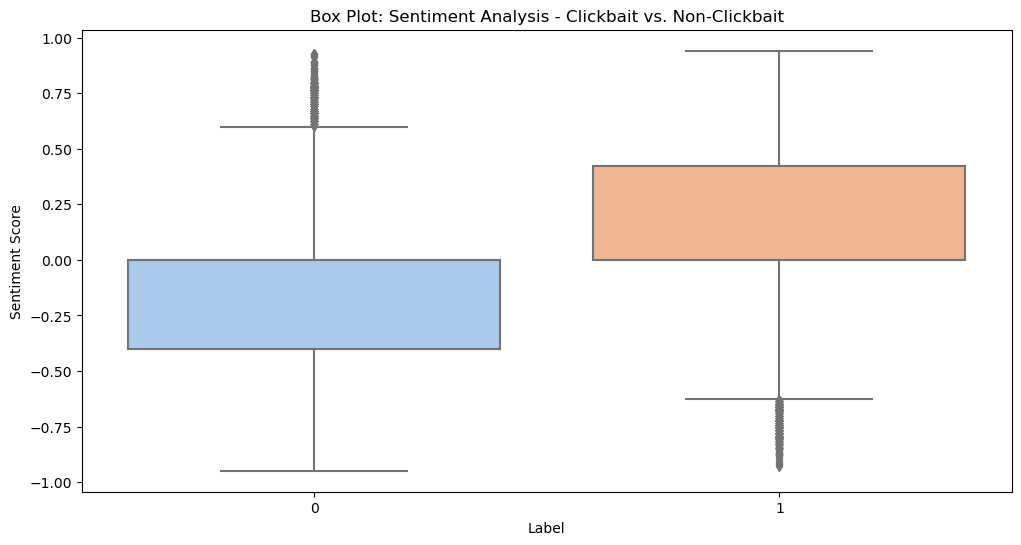

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='sentiment', data=df_all, palette='pastel')
plt.xlabel('Label')
plt.ylabel('Sentiment Score')
plt.title('Box Plot: Sentiment Analysis - Clickbait vs. Non-Clickbait')
plt.show()

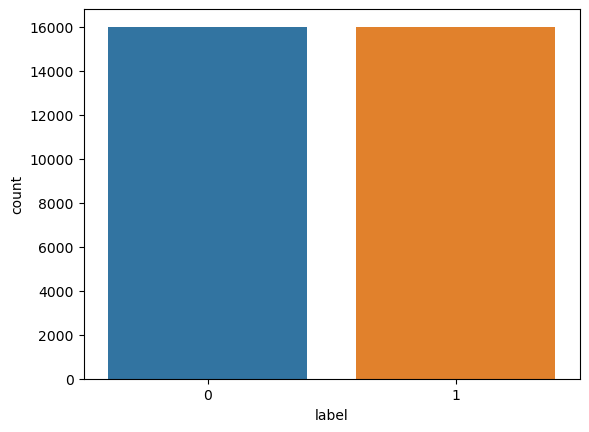

In [9]:
sns.countplot(x=train_data["label"]); # plot the classes

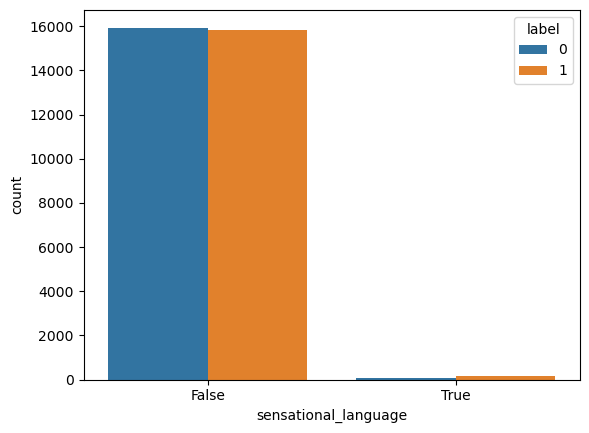

In [10]:
sns.countplot(x='sensational_language', hue='label', data=df_all)
plt.show()

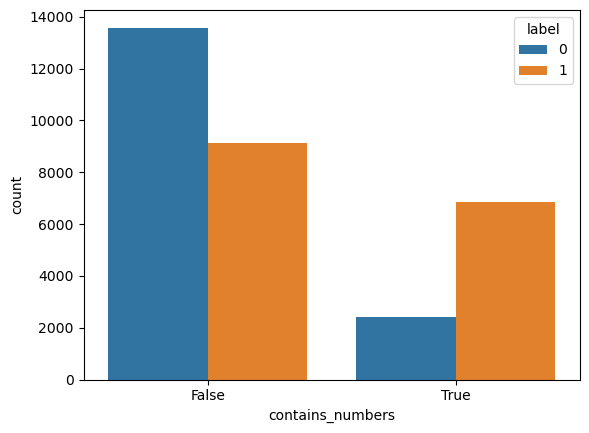

In [11]:
sns.countplot(x='contains_numbers', hue='label', data=df_all)
plt.show()

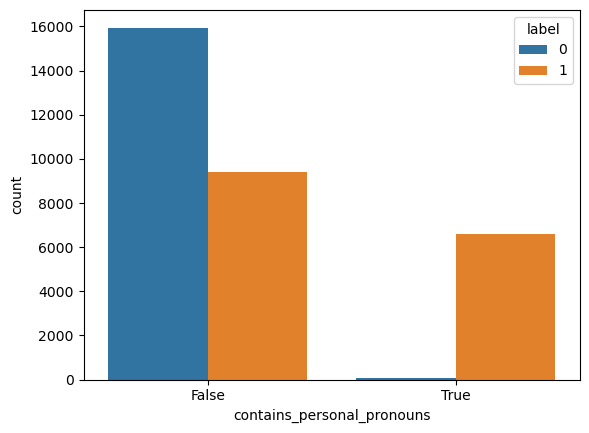

In [12]:
sns.countplot(x='contains_personal_pronouns', hue='label', data=df_all)
plt.show()

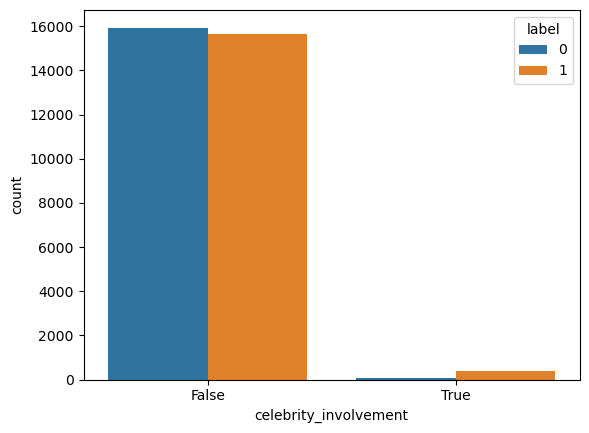

In [13]:
sns.countplot(x='celebrity_involvement', hue='label', data=df_all)
plt.show()

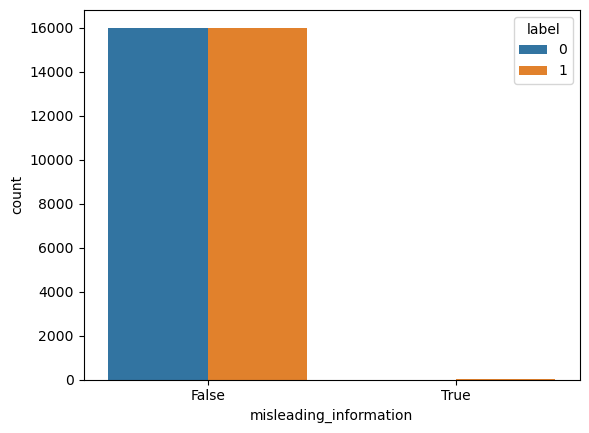

In [14]:
sns.countplot(x='misleading_information', hue='label', data=df_all)
plt.show()

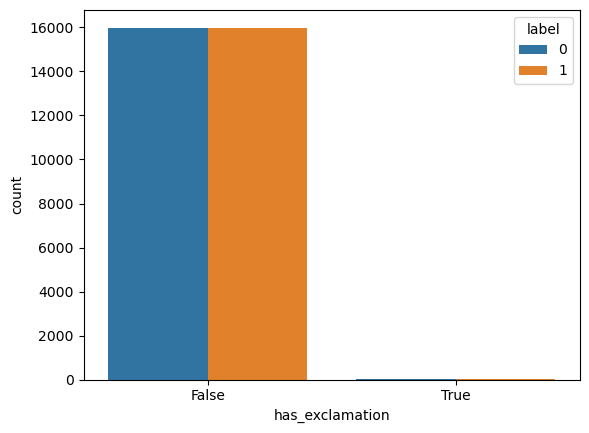

In [15]:
sns.countplot(x='has_exclamation', hue='label', data=df_all)
plt.show()

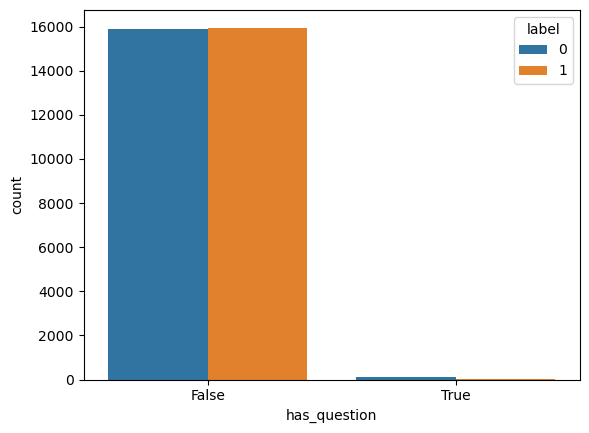

In [16]:
sns.countplot(x='has_question', hue='label', data=df_all)
plt.show()

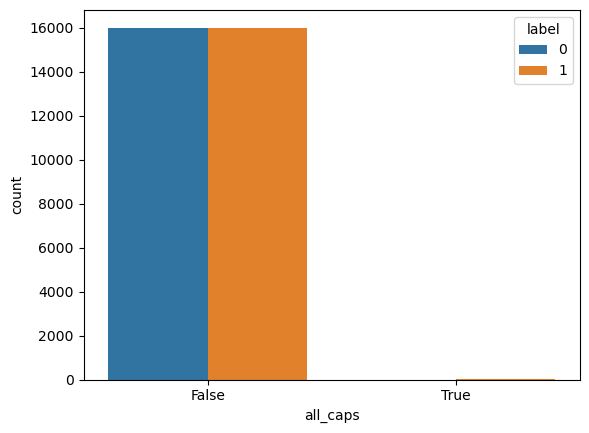

In [17]:
sns.countplot(x='all_caps', hue='label', data=df_all)
plt.show()

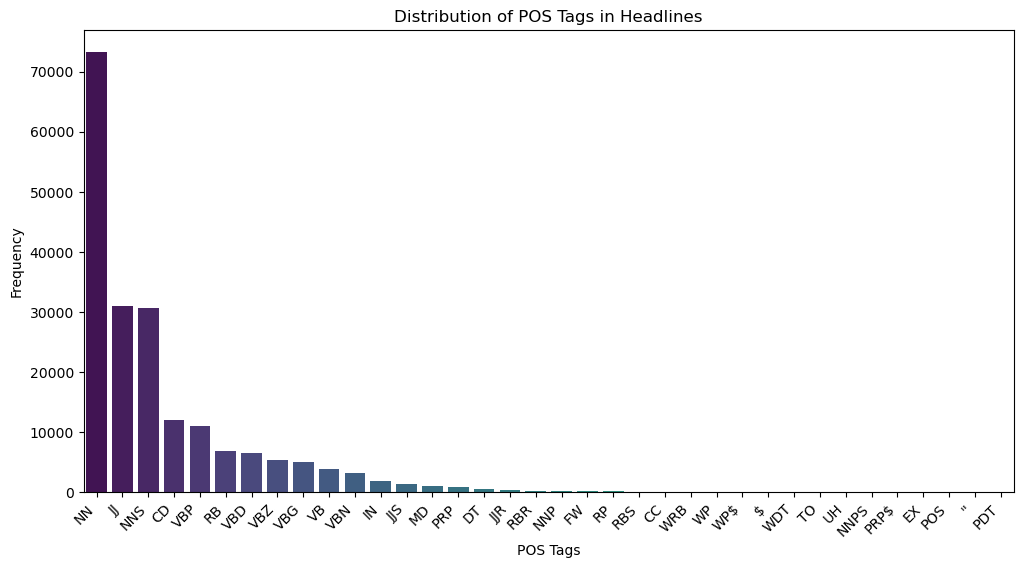

In [18]:
# Function to perform POS analysis on a headline
def pos_analysis(headline):
    # Tokenize the text
    words = word_tokenize(headline)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    # Perform POS tagging
    pos_tags = pos_tag(filtered_words)

    # Extract POS categories
    pos_categories = [tag[1] for tag in pos_tags]

    return pos_categories

# Apply POS analysis to all headlines in the dataset
df_all['pos_tags'] = train_data['headline'].apply(pos_analysis)

# Flatten the list of POS tags for analysis
all_pos_tags = [pos for sublist in df_all['pos_tags'] for pos in sublist]

# Plot the distribution of POS tags
plt.figure(figsize=(12, 6))
pos_tags_series = pd.Series(all_pos_tags)
sns.countplot(x=pos_tags_series, order=pos_tags_series.value_counts().index, palette='viridis')
plt.title('Distribution of POS Tags in Headlines')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

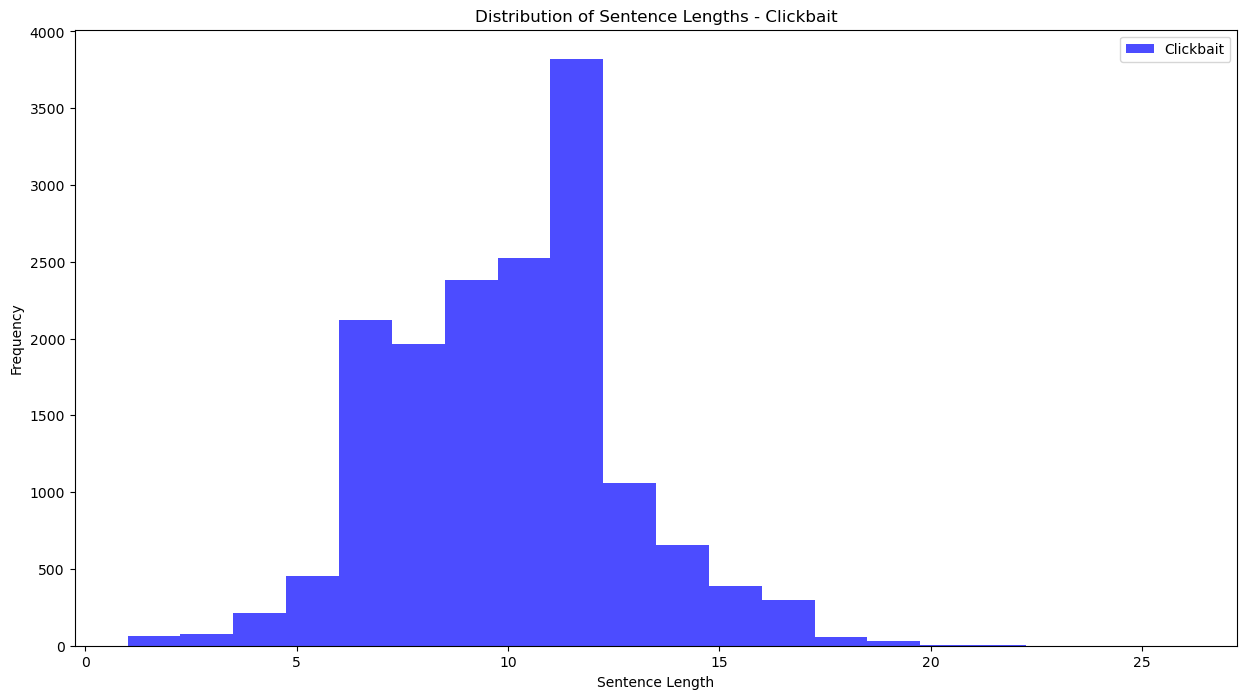

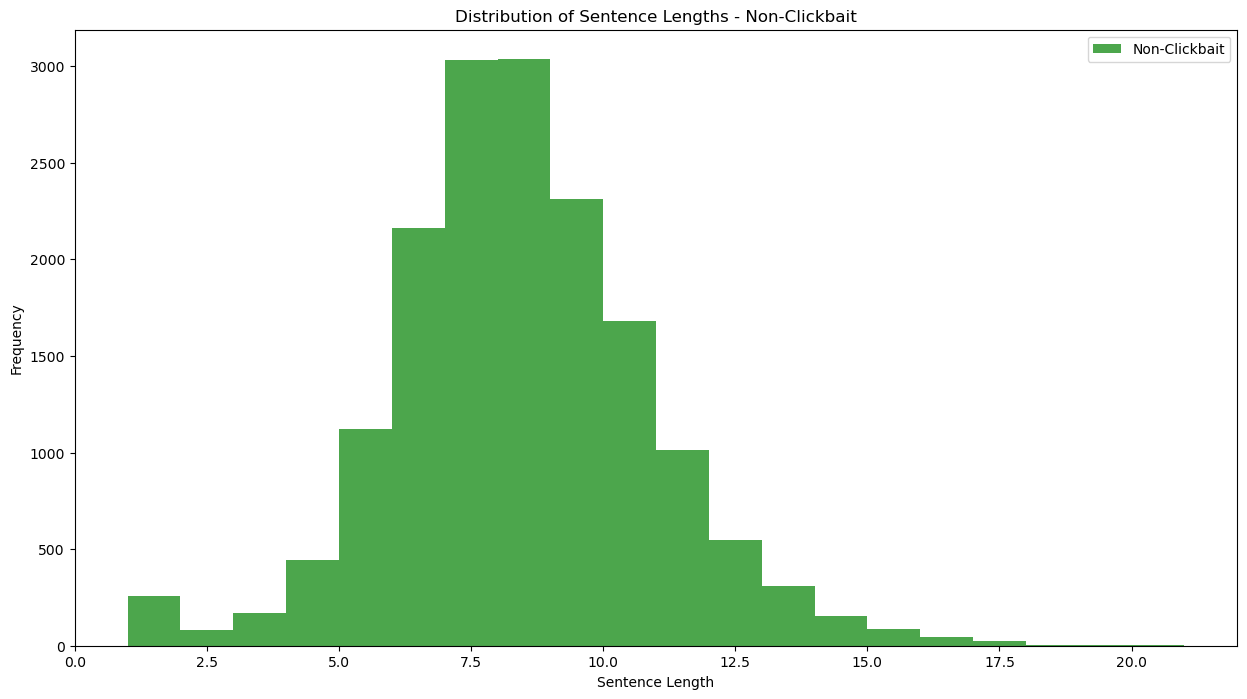

T-Statistic for Sentence Lengths: 66.94645410763495
P-Value for Sentence Lengths: 0.0
The difference in sentence lengths between clickbait and non-clickbait is statistically significant.


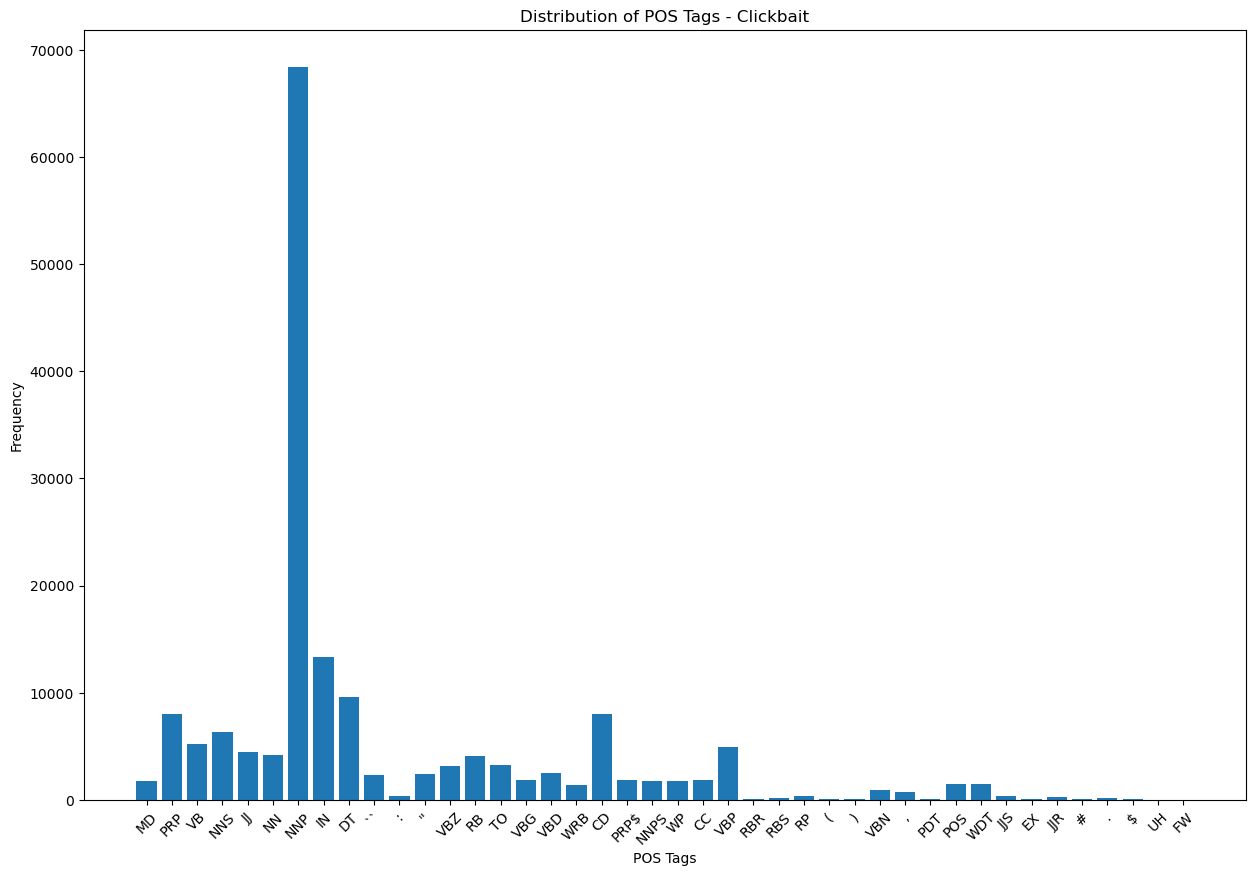

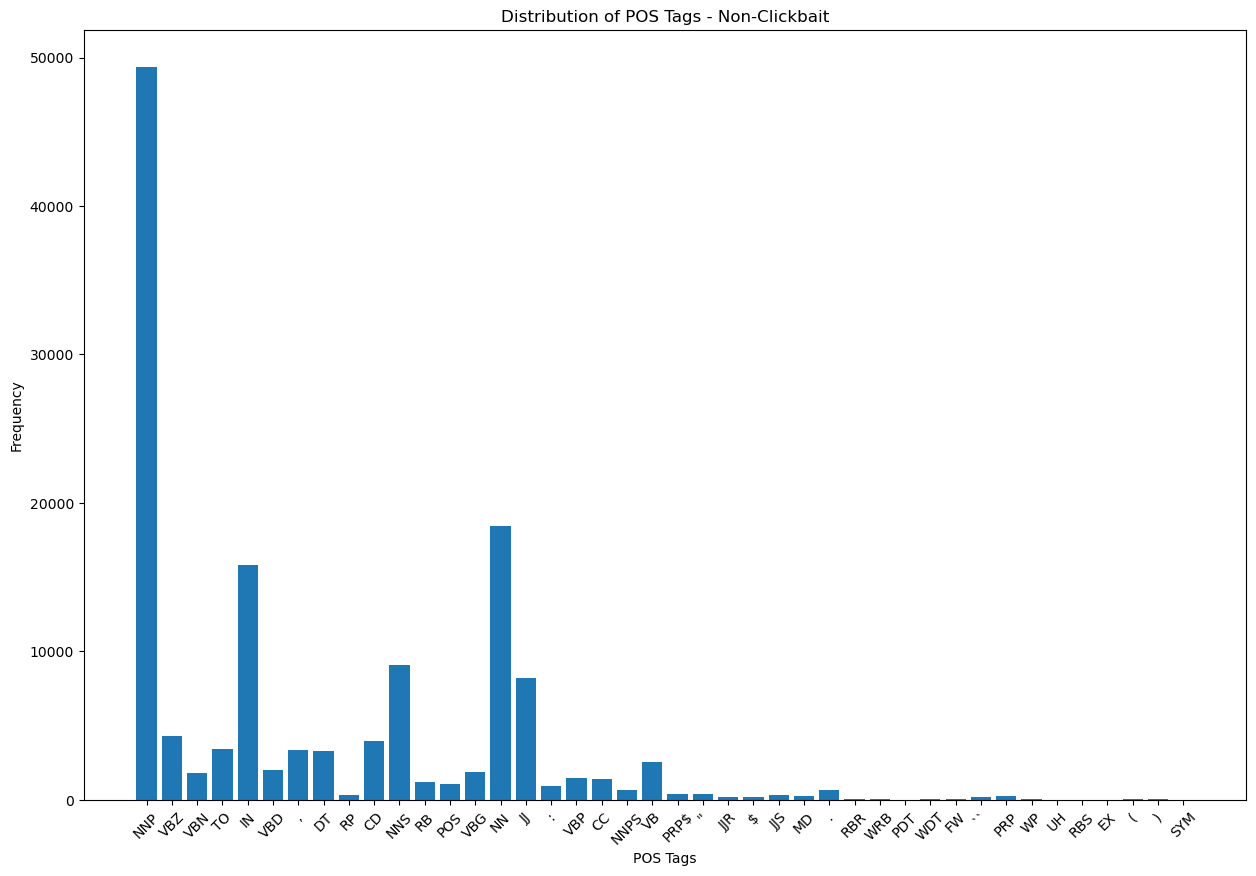

T-Statistic for POS Tags: 0.35925847486527335
P-Value for POS Tags: 0.720325205435347
There is no statistically significant difference in POS tag frequencies between clickbait and non-clickbait.


In [19]:
# Function to perform sentence tokenization and POS tagging on a sentence
def perform_sentence_structure_analysis(sentence):
    sentences = sent_tokenize(sentence)
    sentence_lengths = [len(sentence.split()) for sentence in sentences]
    
    pos_tags = []
    for sent in sentences:
        tokens = nltk.word_tokenize(sent)
        pos_tags.extend(pos_tag(tokens))
    
    return sentence_lengths, pos_tags

# Apply sentence structure analysis to each headline in the DataFrame for clickbait
df_clickbait['SentenceLengths'], df_clickbait['PosTags'] = zip(*train_data[train_data['label'] == 1]['headline'].apply(
    lambda x: perform_sentence_structure_analysis(x)
))

# Apply sentence structure analysis to each headline in the DataFrame for non-clickbait
df_nonclickbait['SentenceLengths'], df_nonclickbait['PosTags'] = zip(*train_data[train_data['label'] == 0]['headline'].apply(
    lambda x: perform_sentence_structure_analysis(x)
))

# Extract sentence lengths and POS tags for analysis
all_sentence_lengths_clickbait = [length for lengths in df_clickbait['SentenceLengths'] for length in lengths]
all_sentence_lengths_nonclickbait = [length for lengths in df_nonclickbait['SentenceLengths'] for length in lengths]

all_pos_tags_clickbait = [tag for tags in df_clickbait['PosTags'] for _, tag in tags]
all_pos_tags_nonclickbait = [tag for tags in df_nonclickbait['PosTags'] for _, tag in tags]

# Plot distribution of sentence lengths for clickbait
plt.figure(figsize=(15, 8))
plt.hist(all_sentence_lengths_clickbait, bins=20, alpha=0.7, color='blue', label='Clickbait')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths - Clickbait')
plt.legend()
plt.show()

# Plot distribution of sentence lengths for non-clickbait
plt.figure(figsize=(15, 8))
plt.hist(all_sentence_lengths_nonclickbait, bins=20, alpha=0.7, color='green', label='Non-Clickbait')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths - Non-Clickbait')
plt.legend()
plt.show()

# Statistical comparison of sentence lengths between clickbait and non-clickbait using t-test
t_stat_sentence_lengths, p_value_sentence_lengths = ttest_ind(all_sentence_lengths_clickbait, all_sentence_lengths_nonclickbait)

print(f'T-Statistic for Sentence Lengths: {t_stat_sentence_lengths}\nP-Value for Sentence Lengths: {p_value_sentence_lengths}')

# Check if the difference is statistically significant for sentence lengths
if p_value_sentence_lengths < 0.05:
    print('The difference in sentence lengths between clickbait and non-clickbait is statistically significant.')
else:
    print('There is no statistically significant difference in sentence lengths between clickbait and non-clickbait.')

# Analyze the distribution of POS tags for clickbait
pos_tag_counts_clickbait = Counter(all_pos_tags_clickbait)
pos_tags_clickbait, counts_pos_tags_clickbait = zip(*pos_tag_counts_clickbait.items())

# Analyze the distribution of POS tags for non-clickbait
pos_tag_counts_nonclickbait = Counter(all_pos_tags_nonclickbait)
pos_tags_nonclickbait, counts_pos_tags_nonclickbait = zip(*pos_tag_counts_nonclickbait.items())

# Plot distribution of POS tags for clickbait
plt.figure(figsize=(15, 10))
plt.bar(pos_tags_clickbait, counts_pos_tags_clickbait)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('Distribution of POS Tags - Clickbait')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of POS tags for non-clickbait
plt.figure(figsize=(15, 10))
plt.bar(pos_tags_nonclickbait, counts_pos_tags_nonclickbait)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('Distribution of POS Tags - Non-Clickbait')
plt.xticks(rotation=45)
plt.show()

# Statistical comparison of POS tag frequencies between clickbait and non-clickbait using t-test
t_stat_pos_tags, p_value_pos_tags = ttest_ind(list(pos_tag_counts_clickbait.values()), list(pos_tag_counts_nonclickbait.values()))

print(f'T-Statistic for POS Tags: {t_stat_pos_tags}\nP-Value for POS Tags: {p_value_pos_tags}')

# Check if the difference is statistically significant for POS tags
if p_value_pos_tags < 0.05:
    print('The difference in POS tag frequencies between clickbait and non-clickbait is statistically significant.')
else:
    print('There is no statistically significant difference in POS tag frequencies between clickbait and non-clickbait.')

In [20]:
# Function to filter POS tags for adjectives and verbs
def filter_adjectives_verbs(tagged_words):
    adjectives = [word for word, tag in tagged_words if tag.startswith('JJ')]
    verbs = [word for word, tag in tagged_words if tag.startswith('VB')]
    nouns = [word for word, tag in tagged_words if tag.startswith('NN')]
    return adjectives, verbs, nouns

# Apply POS tagging and filtering to each headline in the DataFrame for clickbait
df_clickbait['Adjectives'], df_clickbait['Verbs'],df_clickbait['Nouns'] = zip(*train_data[train_data['label'] == 1]['headline'].apply(
    lambda x: filter_adjectives_verbs(pos_tag(word_tokenize(x)))
))

# Apply POS tagging and filtering to each headline in the DataFrame for non-clickbait
df_nonclickbait['Adjectives'], df_nonclickbait['Verbs'],df_nonclickbait['Nouns'] = zip(*train_data[train_data['label'] == 0]['headline'].apply(
    lambda x: filter_adjectives_verbs(pos_tag(word_tokenize(x)))
))

# Extract adjectives and verbs for analysis
all_adjectives_clickbait = [adj for adjs in df_clickbait['Adjectives'] for adj in adjs]
all_verbs_clickbait = [verb for verbs in df_clickbait['Verbs'] for verb in verbs]
all_nouns_clickbait = [noun for nouns in df_clickbait['Nouns'] for noun in nouns]

all_adjectives_nonclickbait = [adj for adjs in df_nonclickbait['Adjectives'] for adj in adjs]
all_verbs_nonclickbait = [verb for verbs in df_nonclickbait['Verbs'] for verb in verbs]
all_nouns_nonclickbait = [noun for nouns in df_nonclickbait['Nouns'] for noun in nouns]

# Plot distribution of adjectives for clickbait
adj_counts_clickbait = Counter(all_adjectives_clickbait)
adjectives_clickbait, counts_adjectives_clickbait = zip(*adj_counts_clickbait.items())

# Plot distribution of adjectives for non-clickbait
adj_counts_nonclickbait = Counter(all_adjectives_nonclickbait)
adjectives_nonclickbait, counts_adjectives_nonclickbait = zip(*adj_counts_nonclickbait.items())

# Plot distribution of verbs for clickbait
verb_counts_clickbait = Counter(all_verbs_clickbait)
verbs_clickbait, counts_verbs_clickbait = zip(*verb_counts_clickbait.items())

# Plot distribution of verbs for non-clickbait
verb_counts_nonclickbait = Counter(all_verbs_nonclickbait)
verbs_nonclickbait, counts_verbs_nonclickbait = zip(*verb_counts_nonclickbait.items())

# Plot distribution of nouns for clickbait
noun_counts_clickbait = Counter(all_nouns_clickbait)
nouns_clickbait, counts_nouns_clickbait = zip(*noun_counts_clickbait.items())

# Plot distribution of verbs for non-clickbait
noun_counts_nonclickbait = Counter(all_nouns_nonclickbait)
nouns_nonclickbait, counts_nouns_nonclickbait = zip(*noun_counts_nonclickbait.items())

# Statistical comparison of adjective frequencies between clickbait and non-clickbait using t-test
t_stat_adj, p_value_adj = ttest_ind(list(adj_counts_clickbait.values()), list(adj_counts_nonclickbait.values()))

# Statistical comparison of verb frequencies between clickbait and non-clickbait using t-test
t_stat_verbs, p_value_verbs = ttest_ind(list(verb_counts_clickbait.values()), list(verb_counts_nonclickbait.values()))

# Statistical comparison of verb frequencies between clickbait and non-clickbait using t-test
t_stat_nouns, p_value_nouns = ttest_ind(list(noun_counts_clickbait.values()), list(noun_counts_nonclickbait.values()))

print(f'T-Statistic for Adjectives: {t_stat_adj}\nP-Value for Adjectives: {p_value_adj}')
print(f'T-Statistic for Verbs: {t_stat_verbs}\nP-Value for Verbs: {p_value_verbs}')
print(f'T-Statistic for Nouns: {t_stat_nouns}\nP-Value for Nouns: {p_value_nouns}')

# Check if the difference is statistically significant for adjectives
if p_value_adj < 0.05:
    print('The difference in adjective frequencies between clickbait and non-clickbait is statistically significant.')
else:
    print('There is no statistically significant difference in adjective frequencies between clickbait and non-clickbait.')

# Check if the difference is statistically significant for verbs
if p_value_verbs < 0.05:
    print('The difference in verb frequencies between clickbait and non-clickbait is statistically significant.')
else:
    print('There is no statistically significant difference in verb frequencies between clickbait and non-clickbait.')
    
# Check if the difference is statistically significant for verbs
if p_value_nouns < 0.05:
    print('The difference in noun frequencies between clickbait and non-clickbait is statistically significant.')
else:
    print('There is no statistically significant difference in noun frequencies between clickbait and non-clickbait.')

T-Statistic for Adjectives: 2.1520529055707844
P-Value for Adjectives: 0.03145915107423594
T-Statistic for Verbs: 6.778344255612041
P-Value for Verbs: 1.3305710426339611e-11
T-Statistic for Nouns: 11.020208412996046
P-Value for Nouns: 3.4827768344590203e-28
The difference in adjective frequencies between clickbait and non-clickbait is statistically significant.
The difference in verb frequencies between clickbait and non-clickbait is statistically significant.
The difference in noun frequencies between clickbait and non-clickbait is statistically significant.


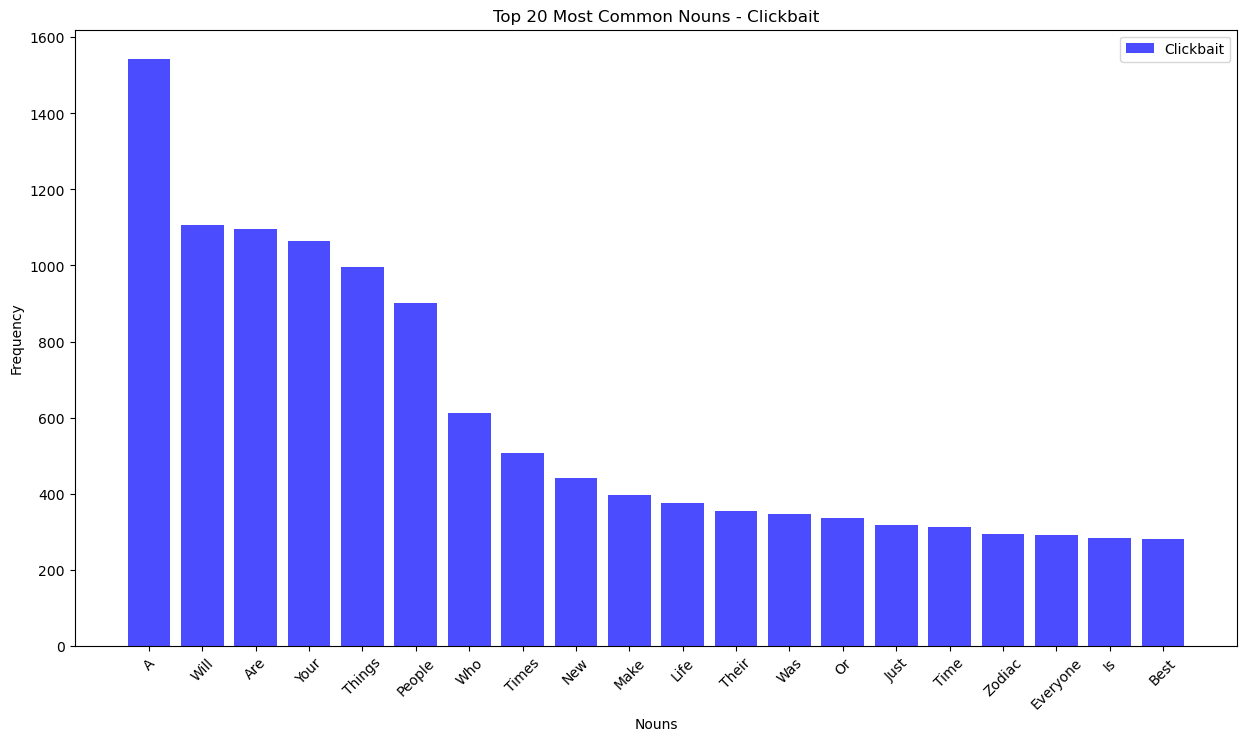

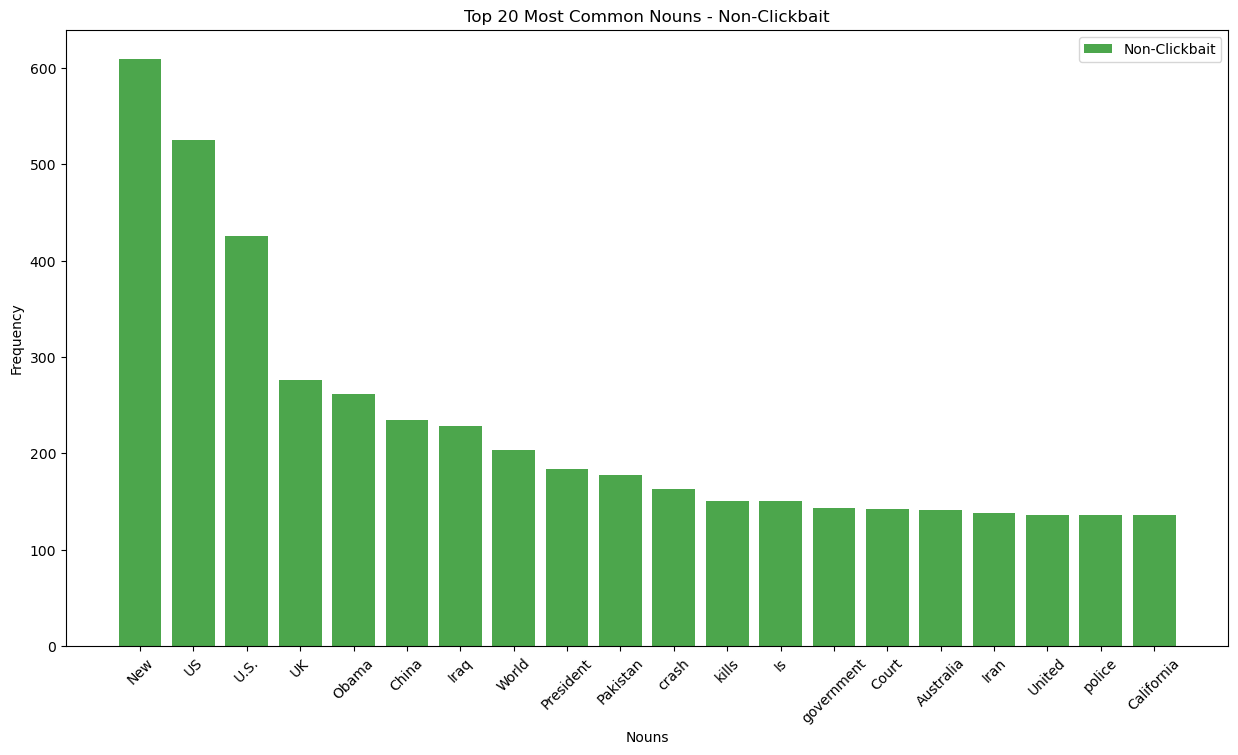

In [21]:
# Choose the top N most common nouns to display
top_n = 20

# Select the top N most common nouns for clickbait
top_nouns_clickbait = dict(noun_counts_clickbait.most_common(top_n))
top_nouns_clickbait, counts_top_nouns_clickbait = zip(*top_nouns_clickbait.items())

# Select the top N most common nouns for non-clickbait
top_nouns_nonclickbait = dict(noun_counts_nonclickbait.most_common(top_n))
top_nouns_nonclickbait, counts_top_nouns_nonclickbait = zip(*top_nouns_nonclickbait.items())

# Plot the distribution of the top N nouns for clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_nouns_clickbait, counts_top_nouns_clickbait, color='blue', alpha=0.7, label='Clickbait')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Nouns - Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of the top N nouns for non-clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_nouns_nonclickbait, counts_top_nouns_nonclickbait, color='green', alpha=0.7, label='Non-Clickbait')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Nouns - Non-Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

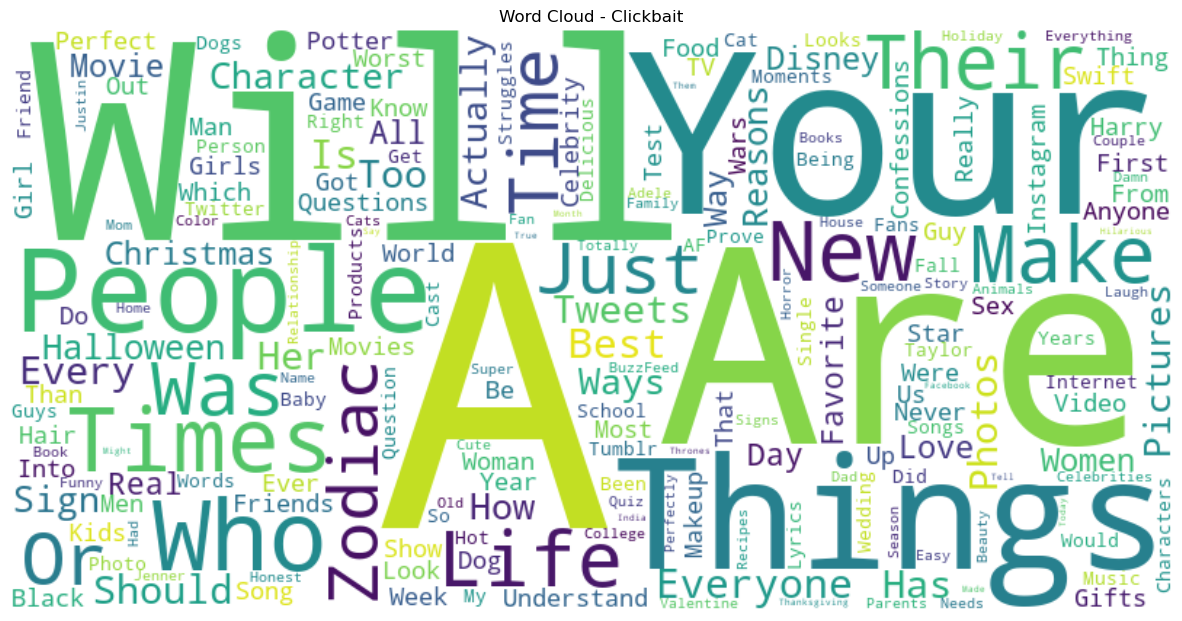

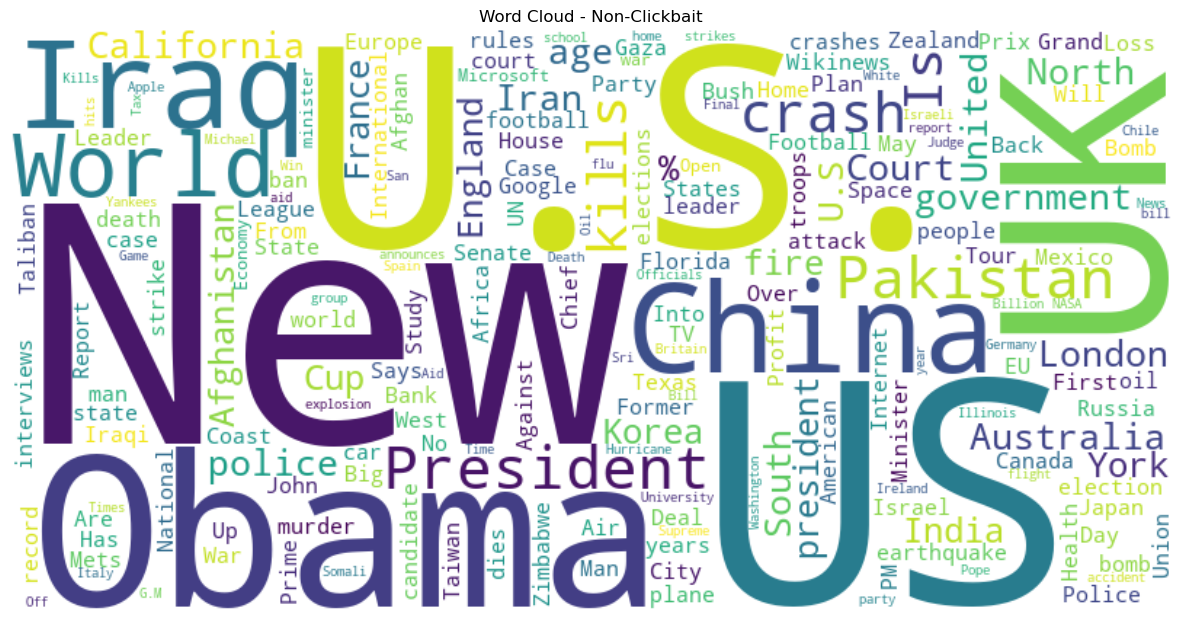

In [22]:
from wordcloud import WordCloud

# Generate word cloud for clickbait
wordcloud_clickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts_clickbait)

# Generate word cloud for non-clickbait
wordcloud_nonclickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts_nonclickbait)

# Plot the word cloud for clickbait
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_clickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Clickbait')
plt.show()

# Plot the word cloud for non-clickbait
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_nonclickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Clickbait')
plt.show()

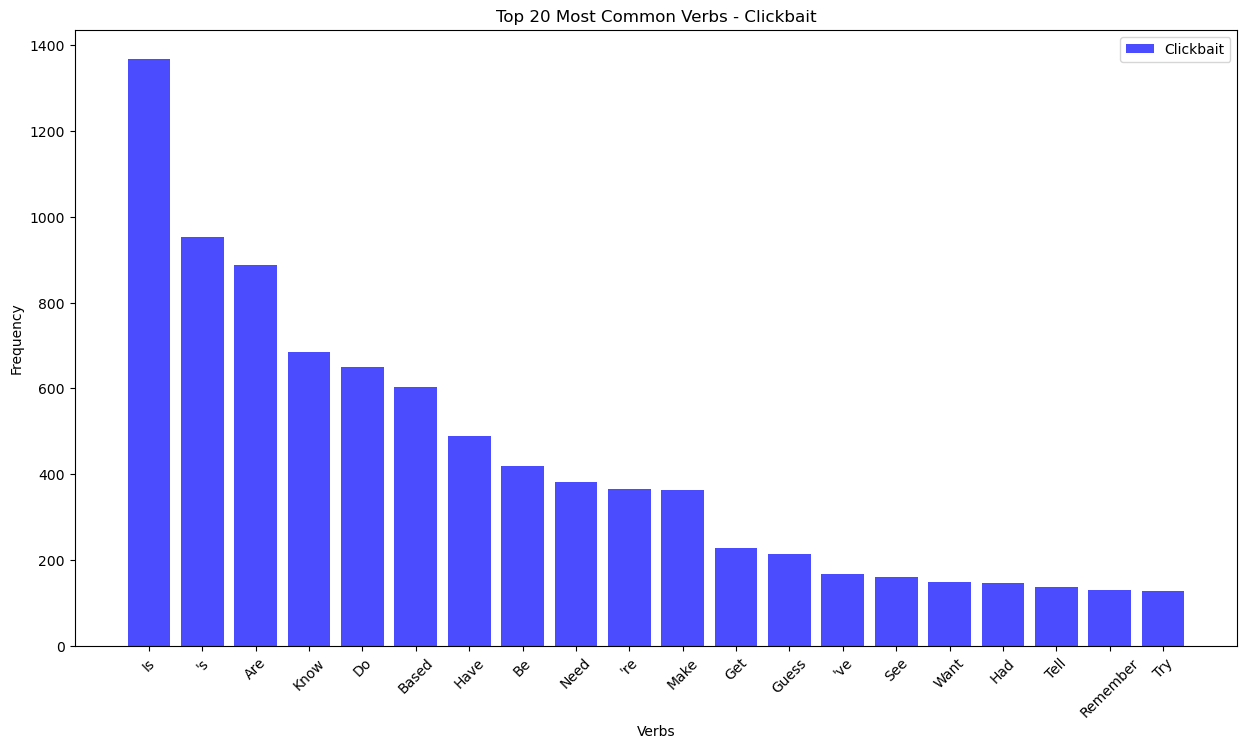

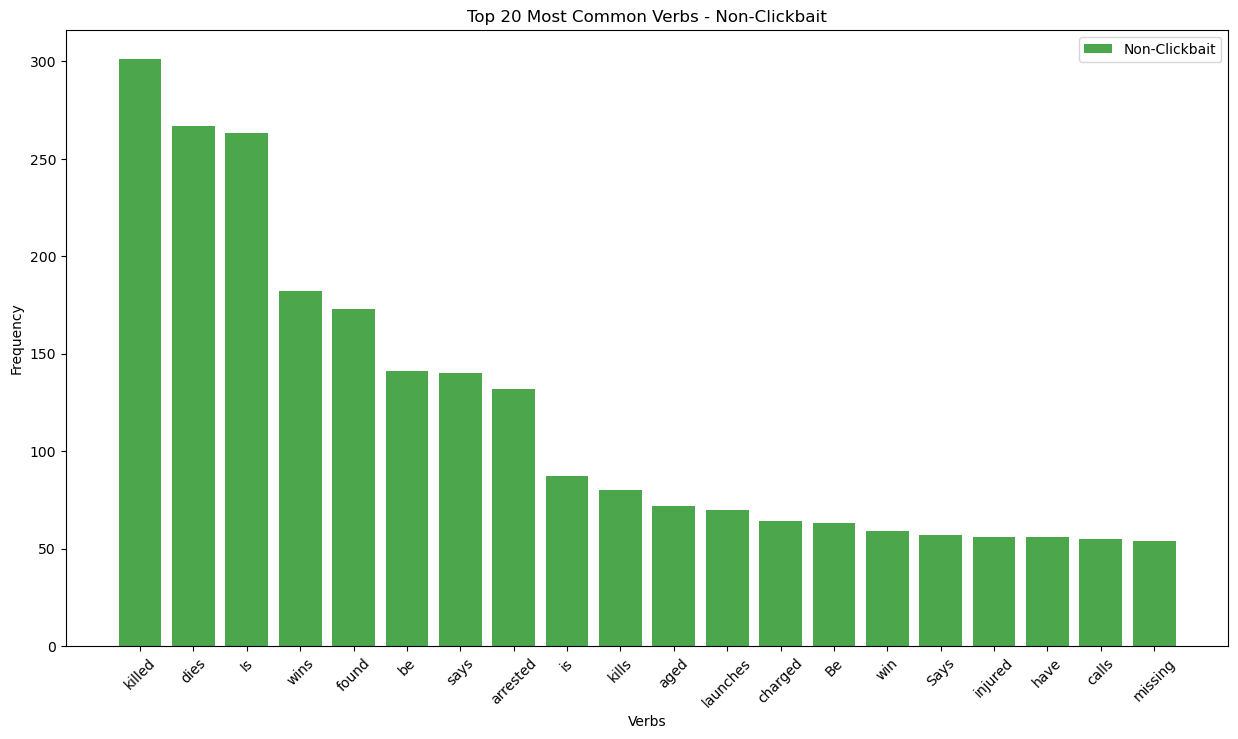

In [23]:
# Choose the top N most common verbs to display
top_n = 20

# Select the top N most common verbs for clickbait
top_verbs_clickbait = dict(verb_counts_clickbait.most_common(top_n))
top_verbs_clickbait, counts_top_verbs_clickbait = zip(*top_verbs_clickbait.items())

# Select the top N most common verbs for non-clickbait
top_verbs_nonclickbait = dict(verb_counts_nonclickbait.most_common(top_n))
top_verbs_nonclickbait, counts_top_verbs_nonclickbait = zip(*top_verbs_nonclickbait.items())

# Plot the distribution of the top N verbs for clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_verbs_clickbait, counts_top_verbs_clickbait, color='blue', alpha=0.7, label='Clickbait')
plt.xlabel('Verbs')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Verbs - Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of the top N verbs for non-clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_verbs_nonclickbait, counts_top_verbs_nonclickbait, color='green', alpha=0.7, label='Non-Clickbait')
plt.xlabel('Verbs')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Verbs - Non-Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

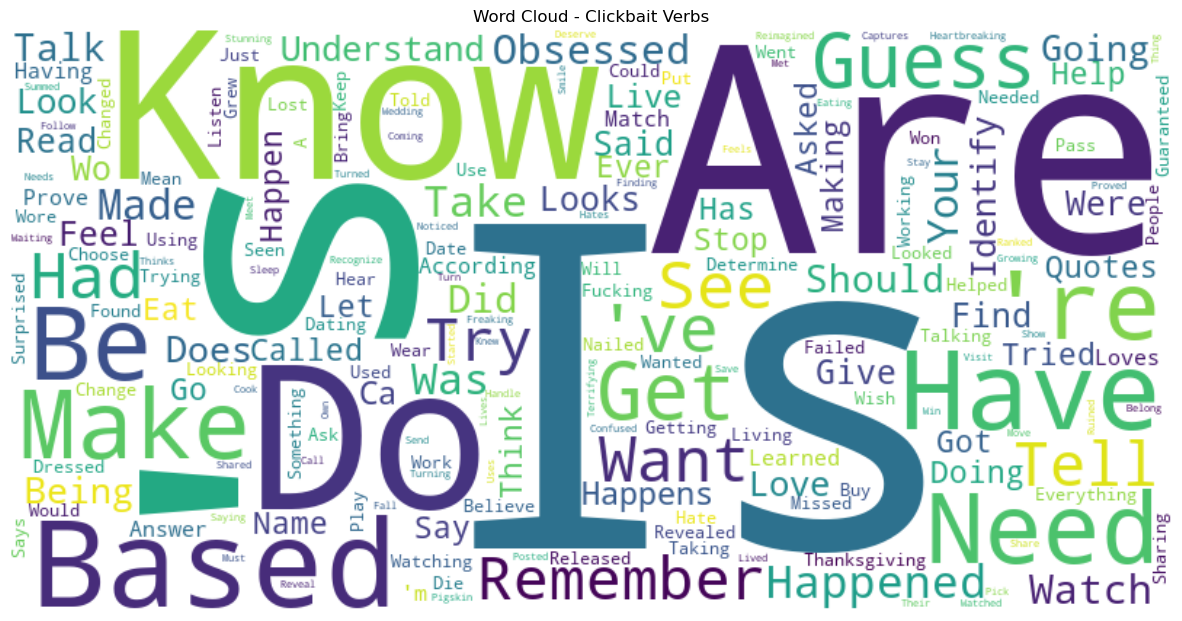

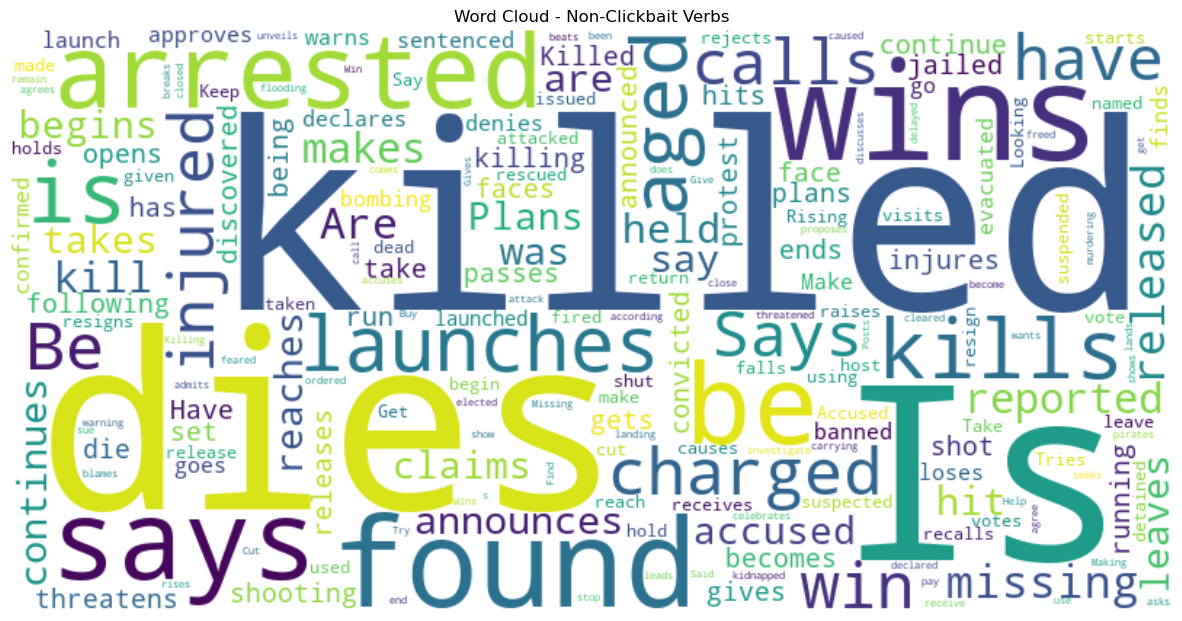

In [24]:
# Generate word cloud for clickbait verbs
wordcloud_verbs_clickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(verb_counts_clickbait)

# Generate word cloud for non-clickbait verbs
wordcloud_verbs_nonclickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(verb_counts_nonclickbait)

# Plot the word cloud for clickbait verbs
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_verbs_clickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Clickbait Verbs')
plt.show()

# Plot the word cloud for non-clickbait verbs
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_verbs_nonclickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Clickbait Verbs')
plt.show()

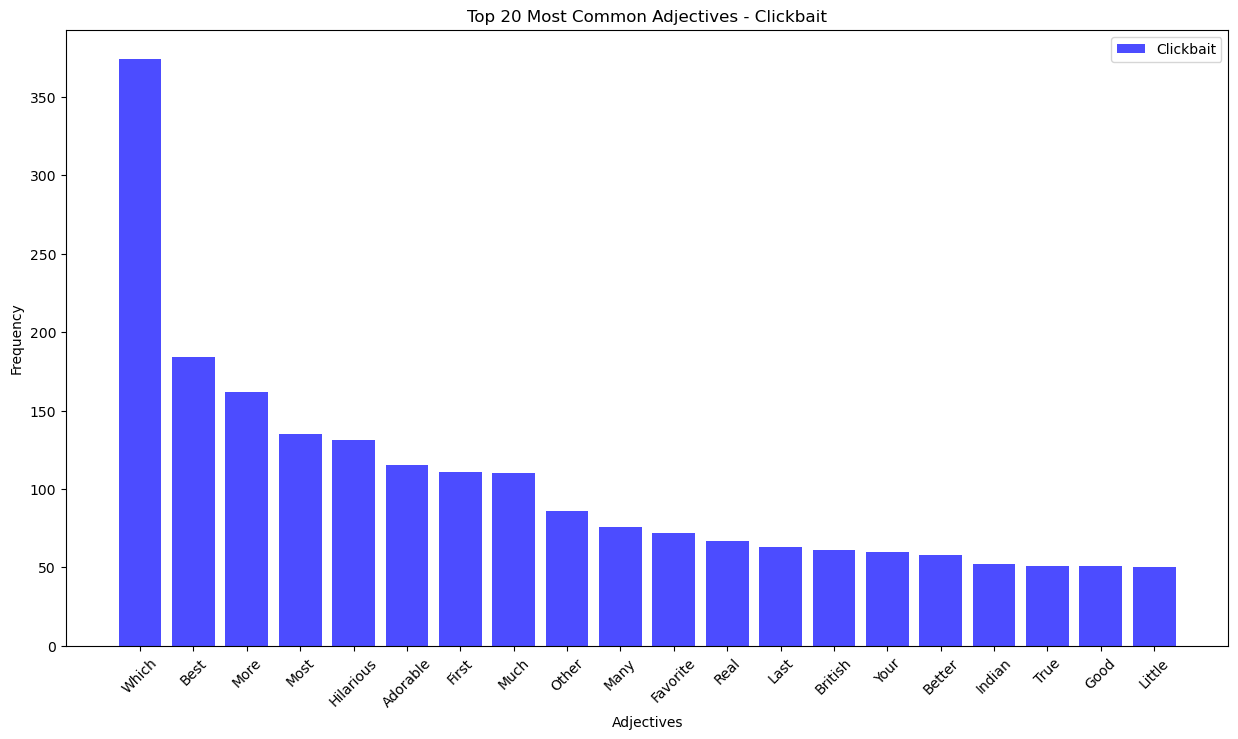

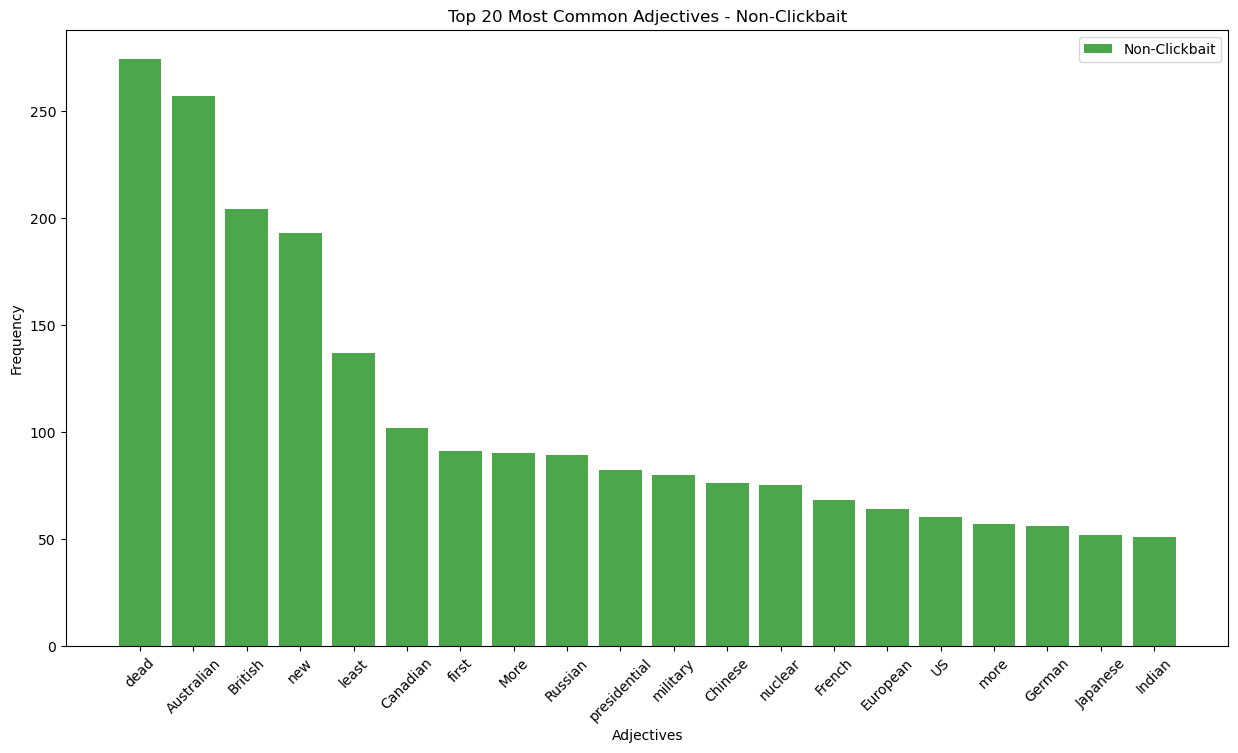

In [25]:
# Choose the top N most common adjectives to display
top_n = 20

# Select the top N most common adjectives for clickbait
top_adjectives_clickbait = dict(adj_counts_clickbait.most_common(top_n))
top_adjectives_clickbait, counts_top_adjectives_clickbait = zip(*top_adjectives_clickbait.items())

# Select the top N most common adjectives for non-clickbait
top_adjectives_nonclickbait = dict(adj_counts_nonclickbait.most_common(top_n))
top_adjectives_nonclickbait, counts_top_adjectives_nonclickbait = zip(*top_adjectives_nonclickbait.items())

# Plot the distribution of the top N adjectives for clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_adjectives_clickbait, counts_top_adjectives_clickbait, color='blue', alpha=0.7, label='Clickbait')
plt.xlabel('Adjectives')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Adjectives - Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of the top N adjectives for non-clickbait
plt.figure(figsize=(15, 8))
plt.bar(top_adjectives_nonclickbait, counts_top_adjectives_nonclickbait, color='green', alpha=0.7, label='Non-Clickbait')
plt.xlabel('Adjectives')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Adjectives - Non-Clickbait')
plt.legend()
plt.xticks(rotation=45)
plt.show()

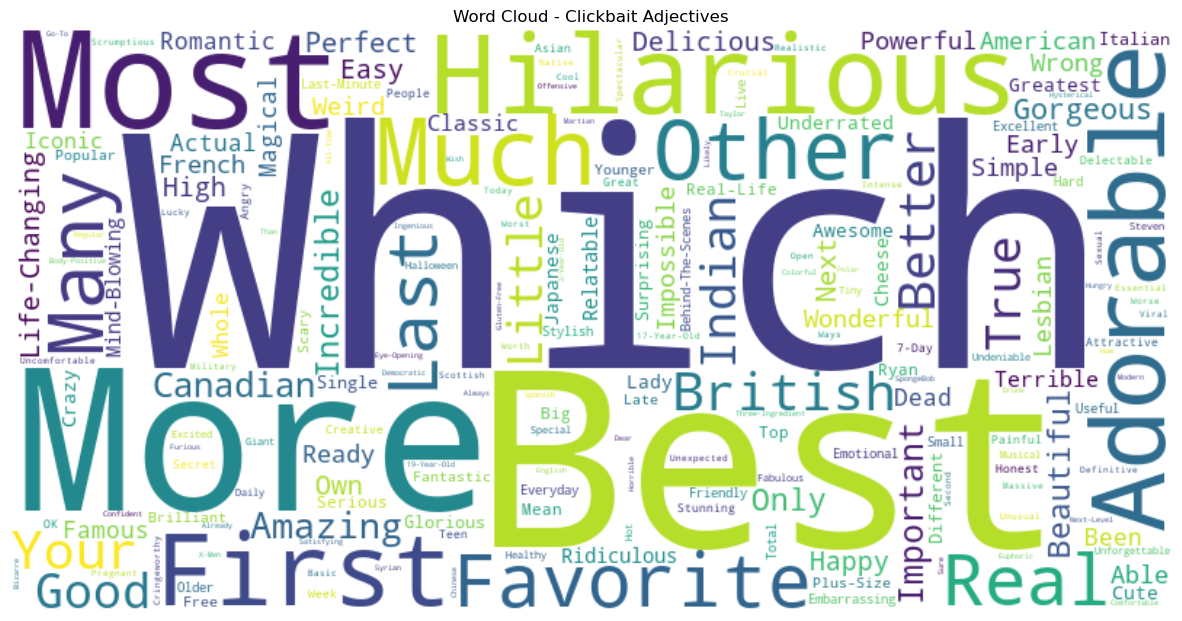

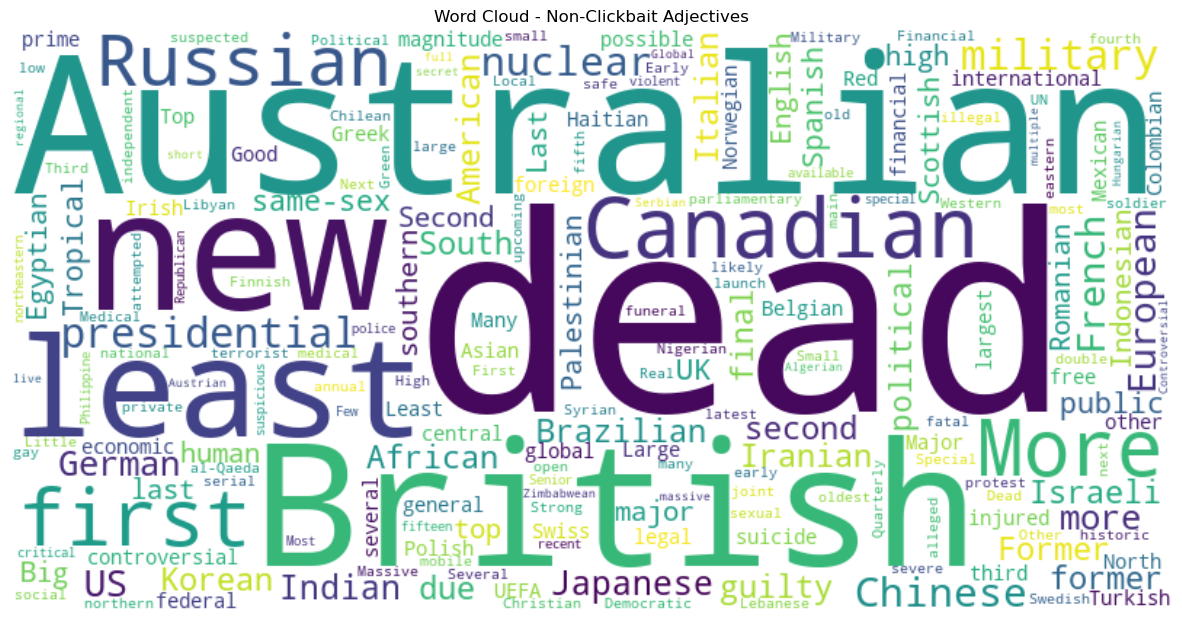

In [26]:
# Generate word cloud for clickbait adjectives
wordcloud_adjectives_clickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adj_counts_clickbait)

# Generate word cloud for non-clickbait adjectives
wordcloud_adjectives_nonclickbait = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adj_counts_nonclickbait)

# Plot the word cloud for clickbait adjectives
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_adjectives_clickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Clickbait Adjectives')
plt.show()

# Plot the word cloud for non-clickbait adjectives
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_adjectives_nonclickbait, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Clickbait Adjectives')
plt.show()

In [27]:
# Convert lists of nouns, adjectives, and verbs to sets
set_nouns_clickbait = set(all_nouns_clickbait)
set_nouns_nonclickbait = set(all_nouns_nonclickbait)

set_adjectives_clickbait = set(all_adjectives_clickbait)
set_adjectives_nonclickbait = set(all_adjectives_nonclickbait)

set_verbs_clickbait = set(all_verbs_clickbait)
set_verbs_nonclickbait = set(all_verbs_nonclickbait)

# Check for overlapping nouns
overlap_nouns = set_nouns_clickbait.intersection(set_nouns_nonclickbait)

# Check for overlapping adjectives
overlap_adjectives = set_adjectives_clickbait.intersection(set_adjectives_nonclickbait)

# Check for overlapping verbs
overlap_verbs = set_verbs_clickbait.intersection(set_verbs_nonclickbait)

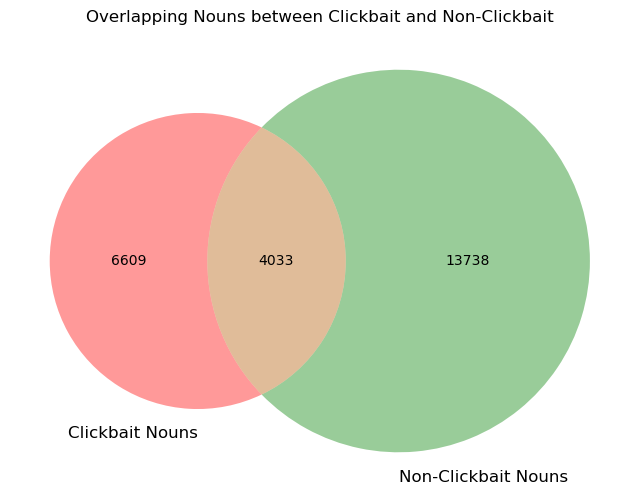

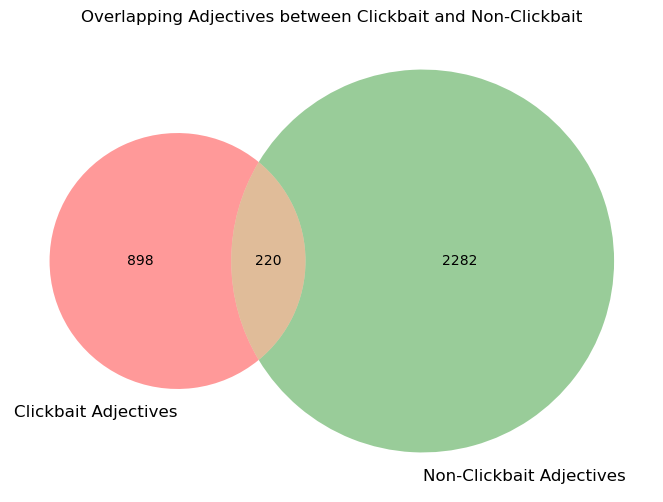

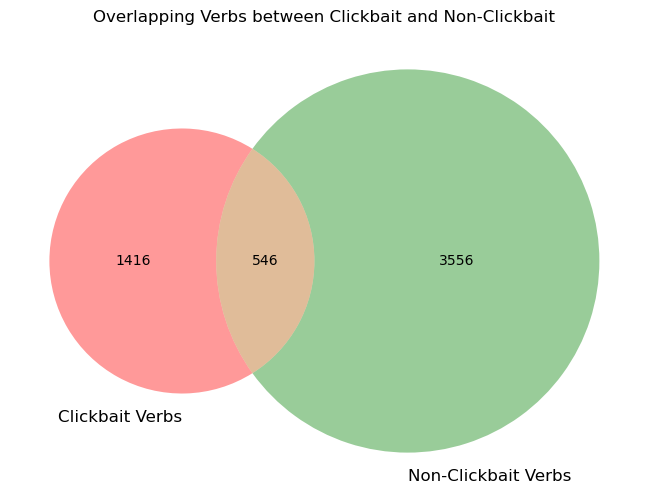

In [28]:
from matplotlib_venn import venn2

# Create Venn diagram for overlapping nouns
plt.figure(figsize=(10, 6))
venn2([set_nouns_clickbait, set_nouns_nonclickbait], set_labels=('Clickbait Nouns', 'Non-Clickbait Nouns'))
plt.title('Overlapping Nouns between Clickbait and Non-Clickbait')
plt.show()

# Create Venn diagram for overlapping adjectives
plt.figure(figsize=(10, 6))
venn2([set_adjectives_clickbait, set_adjectives_nonclickbait], set_labels=('Clickbait Adjectives', 'Non-Clickbait Adjectives'))
plt.title('Overlapping Adjectives between Clickbait and Non-Clickbait')
plt.show()

# Create Venn diagram for overlapping verbs
plt.figure(figsize=(10, 6))
venn2([set_verbs_clickbait, set_verbs_nonclickbait], set_labels=('Clickbait Verbs', 'Non-Clickbait Verbs'))
plt.title('Overlapping Verbs between Clickbait and Non-Clickbait')
plt.show()


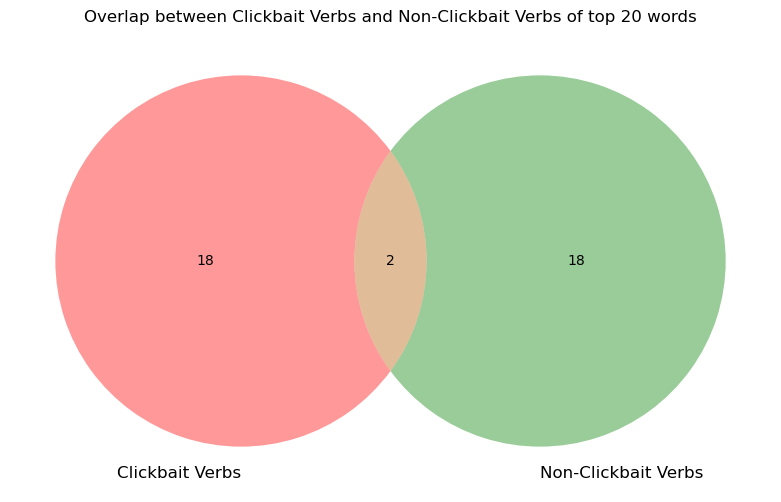

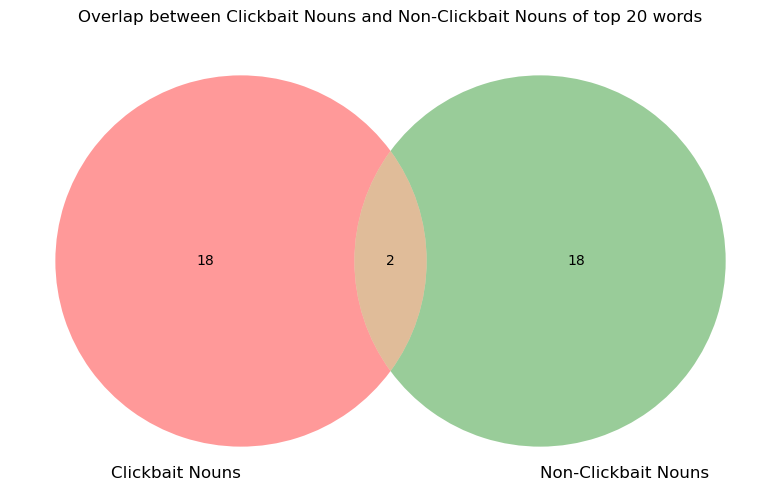

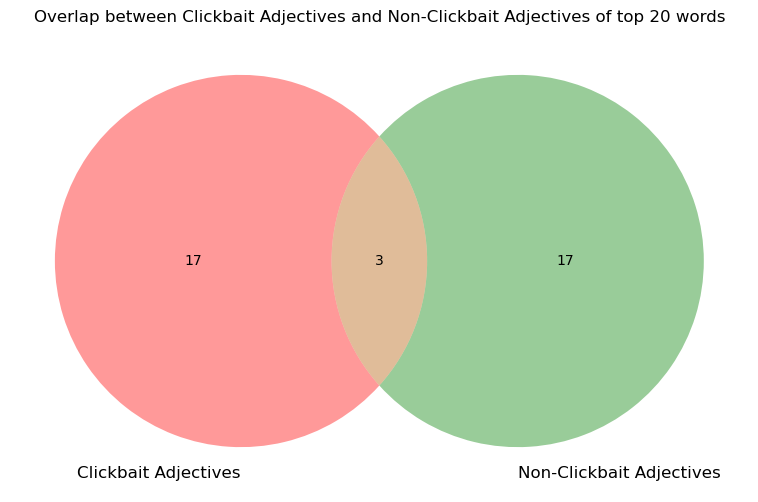

In [29]:
overlap_verbs = set(top_verbs_clickbait) & set(top_verbs_nonclickbait)
overlap_nouns = set(top_nouns_clickbait) & set(top_nouns_nonclickbait)
overlap_adjectives = set(top_adjectives_clickbait) & set(top_adjectives_nonclickbait)

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Function to create a Venn diagram
def plot_venn_diagram(set1, set2, set1_label, set2_label):
    plt.figure(figsize=(10, 6))
    venn = venn2([set1, set2], set_labels=(set1_label, set2_label))
    plt.title(f'Overlap between {set1_label} and {set2_label} of top 20 words')
    plt.show()

# Visualize overlap for verbs
plot_venn_diagram(set(top_verbs_clickbait), set(top_verbs_nonclickbait), 'Clickbait Verbs', 'Non-Clickbait Verbs')

# Visualize overlap for nouns
plot_venn_diagram(set(top_nouns_clickbait), set(top_nouns_nonclickbait), 'Clickbait Nouns', 'Non-Clickbait Nouns')

# Visualize overlap for adjectives
plot_venn_diagram(set(top_adjectives_clickbait), set(top_adjectives_nonclickbait), 'Clickbait Adjectives', 'Non-Clickbait Adjectives')

# Topic Analysis

In [30]:
# Function to plot the topics
def plot_lda_topics(lda_model, feature_names, num_top_words=10):
    num_topics = len(lda_model.components_)
    num_rows = (num_topics - 1) // 3 + 1
    num_cols = min(num_topics, 3)

    plt.figure(figsize=(15, 8))
    for i, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[idx] for idx in top_words_idx]
        weights = topic[top_words_idx]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.barh(top_words, weights, color='skyblue')
        plt.title(f'Topic {i + 1}')
        plt.xlabel('Weight')

    plt.tight_layout()
    plt.show()

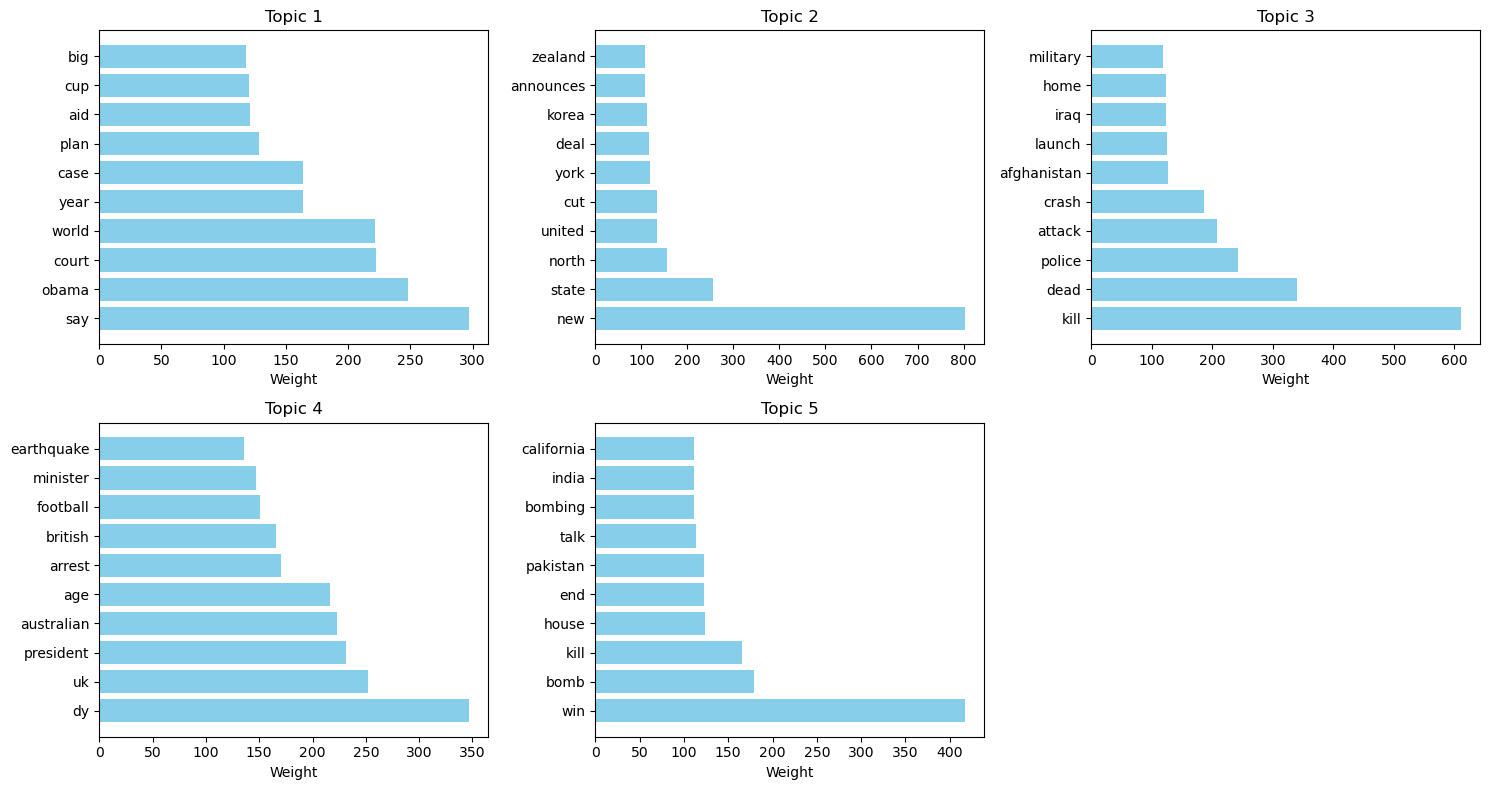

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

data = pd.read_csv('clickbait_data_preprocessed.csv')

# Assuming df_nonclickbait is your DataFrame for clickbait headlines
nonclickbait_headlines = data[data['label'] == 0]['all_cleaned']

# Convert clickbait headlines to a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
bow_matrix = vectorizer.fit_transform(nonclickbait_headlines)

# Apply LDA to extract topics
num_topics = 5  # You can adjust the number of topics based on your needs
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(bow_matrix)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]

# Display the topics using the trained LDA model
plot_lda_topics(lda, feature_names)

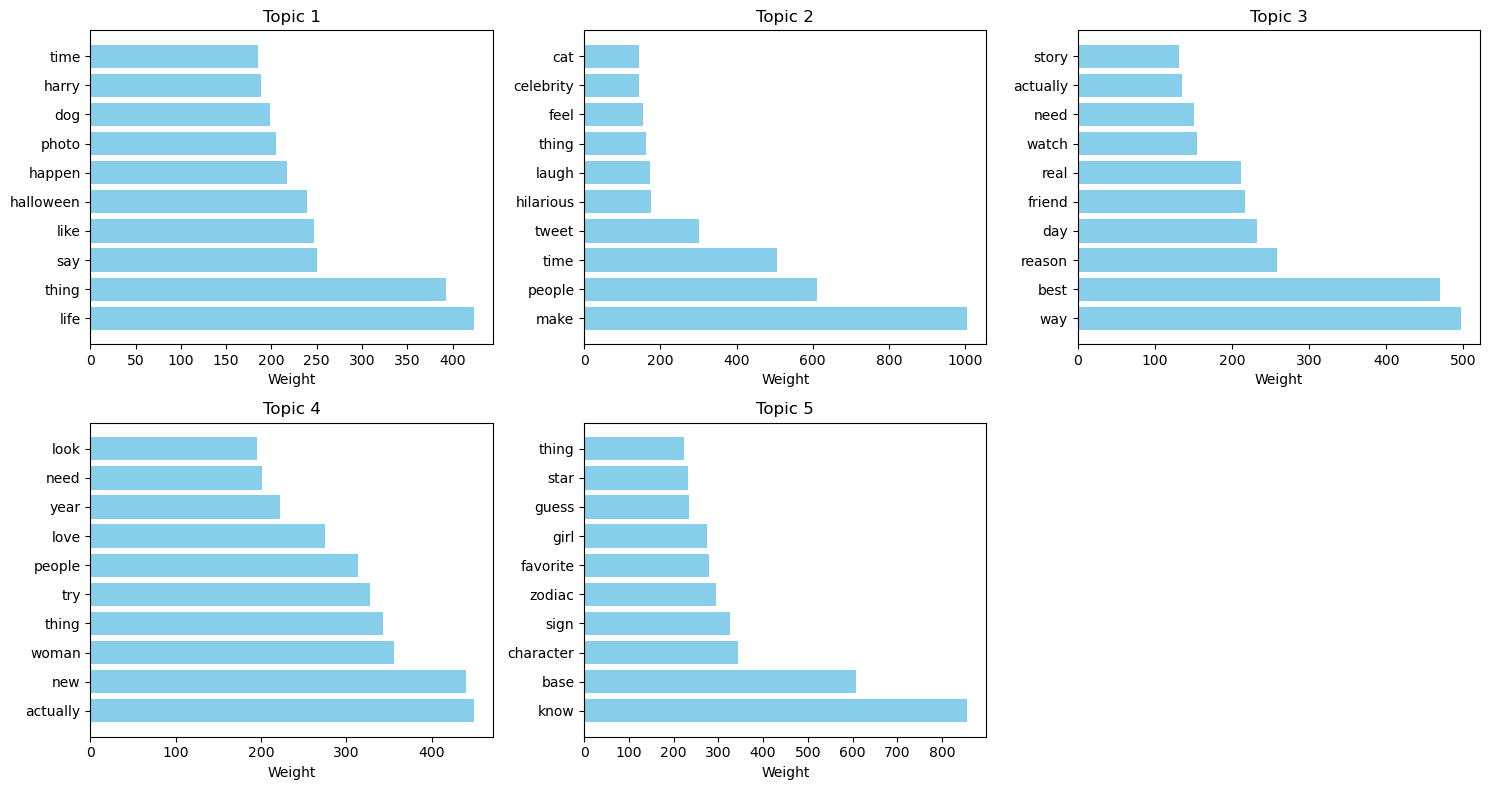

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming df_clickbait is your DataFrame for clickbait headlines
df_test = data
df_test = df_test.dropna(subset=['all_cleaned'])
clickbait_headlines = df_test[df_test['label'] == 1]['all_cleaned']

# Convert clickbait headlines to a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
bow_matrix = vectorizer.fit_transform(clickbait_headlines)

# Apply LDA to extract topics
num_topics = 5  # You can adjust the number of topics based on your needs
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(bow_matrix)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    
# Display the topics using the trained LDA model
plot_lda_topics(lda, feature_names)

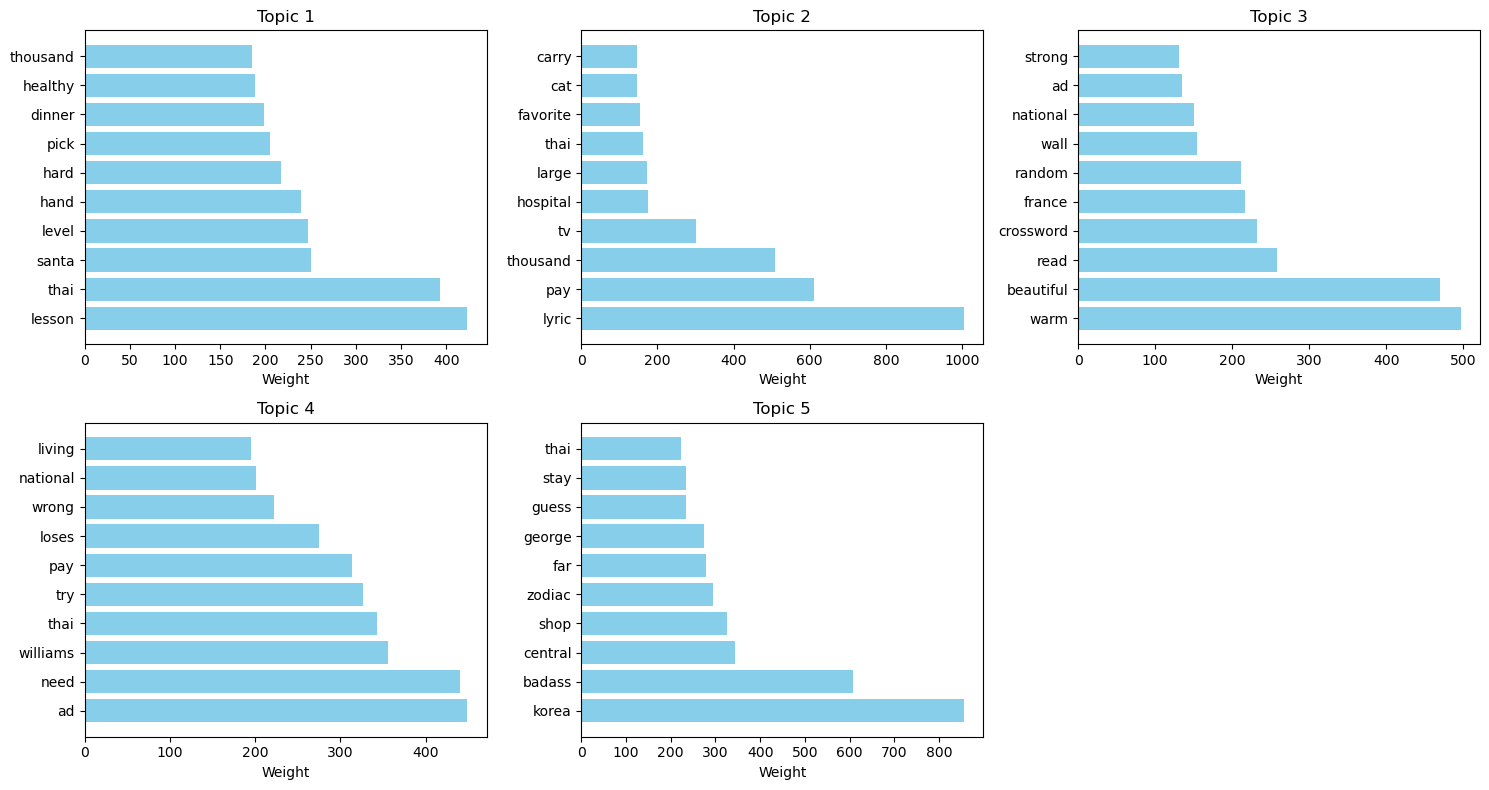

In [33]:
# Assuming df_clickbait is your DataFrame for non clickbait headlines
headlines = df_test['all_cleaned']

# Convert clickbait headlines to TF-IDF matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(headlines)

# Apply LDA to extract topics
num_topics = 5  # You can adjust the number of topics based on your needs
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(bow_matrix)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]

# Display the topics using the trained LDA model
plot_lda_topics(lda, feature_names)

df_all = df_all.iloc[:tfidf_matrix.shape[0]]
df_all['topic_distribution'] = lda.transform(tfidf_matrix).argmax(axis=1)

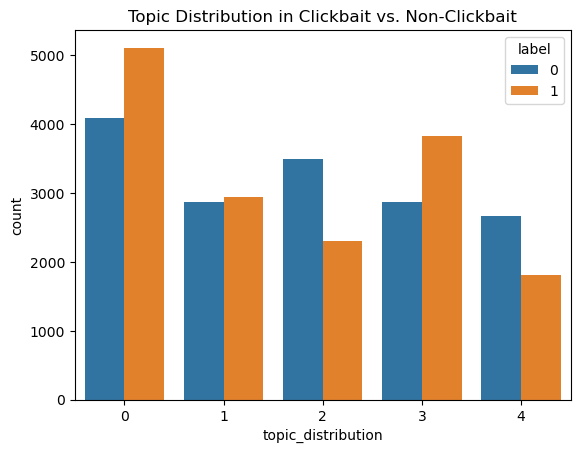

In [34]:
sns.countplot(x='topic_distribution', hue='label', data=df_all)
plt.title('Topic Distribution in Clickbait vs. Non-Clickbait')
plt.show()

In [35]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Example function to extract named entities from a text
def extract_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

# Apply NER to your headlines
df_clickbait['named_entities'] = df_test[df_test['label']==1]['all_cleaned'].apply(extract_named_entities)

In [36]:
#df_nonclickbait['named_entities'] = data[data['label']==0]['all_cleaned'].apply(extract_named_entities)
#data[data['label']==0]['all_cleaned']
# Apply POS tagging to each sentence in the DataFrame
test = train_data[train_data['label'] == 0]['headline'].apply(extract_named_entities)

# Create a new DataFrame with the result and reset the index
df_nonclickbait = pd.DataFrame({'headline': test.values})
df_nonclickbait['named_entities'] = test.reset_index(drop=True)

# Drop rows with missing POS tags
df_nonclickbait = df_nonclickbait.dropna(subset=['named_entities'])

# Print the resulting DataFrame
print(df_nonclickbait[ 'named_entities'].head())

0    [Bill Changing Credit Card, Obama With Gun Mea...
1      [Hollywood, the Easy-Money Generation Toughens]
2                            [1700, UK, Lake District]
3             [Yankees Pitchers Trade Fielding Drills]
4                       [Indonesia, Seventh, two days]
Name: named_entities, dtype: object


In [37]:
# Flatten the list of named entities
df_clickbait = df_clickbait.dropna(subset=['named_entities']) 
all_named_entities= [entity for entities in df_clickbait['named_entities'] for entity in entities]

all_named_entities = [entity for entity in all_named_entities if len(entity) >= 2]

# Count the occurrences of each entity type
entity_counts_clickbait = Counter([entity for entity in all_named_entities])

#Get top 30 entities in clickbait news headlines
top_30_clickbait = dict(sorted(entity_counts_clickbait.items(), key=lambda x: x[1], reverse=True)[:30])

In [38]:
# Flatten the list of named entities
df_nonclickbait = df_nonclickbait.dropna(subset=['named_entities']) 
all_named_entities= [entity for entities in df_nonclickbait['named_entities'] for entity in entities]

all_named_entities = [entity for entity in all_named_entities if len(entity) >= 2]

# Count the occurrences of each entity type
entity_counts_nonclickbait = Counter([entity for entity in all_named_entities])

#Get top 30 entities in non clickbait news headlines
top_30_nonclickbait = dict(sorted(entity_counts_nonclickbait.items(), key=lambda x: x[1], reverse=True)[:30])

In [39]:
df_nonclickbait['named_entities']

0        [Bill Changing Credit Card, Obama With Gun Mea...
1          [Hollywood, the Easy-Money Generation Toughens]
2                                [1700, UK, Lake District]
3                 [Yankees Pitchers Trade Fielding Drills]
4                           [Indonesia, Seventh, two days]
                               ...                        
15996                                               [Iraq]
15997                [British, Democrat, Patsy Calton, 56]
15998                                                   []
15999                  [Netanyahu, Benedict, Israel, Iran]
16000                    [Computer Makers Prepare, Phones]
Name: named_entities, Length: 16001, dtype: object

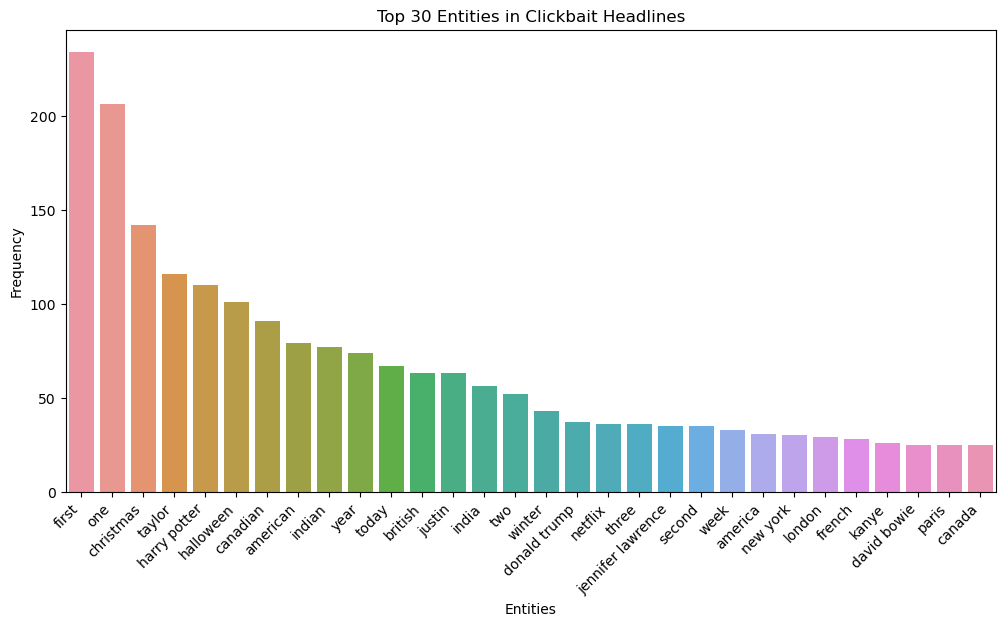

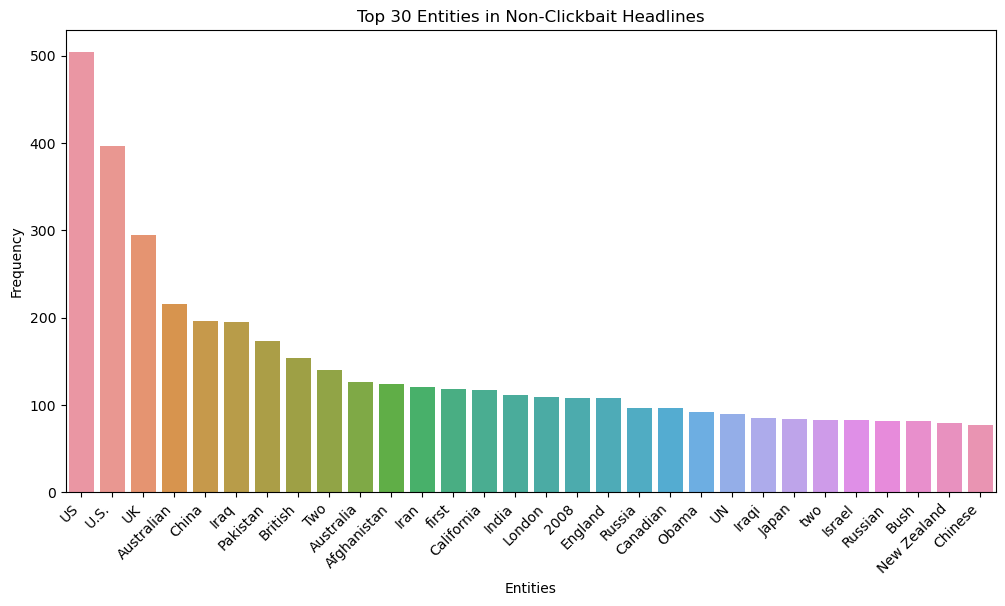

In [40]:
# Function to plot bar graphs for top entities
def plot_top_entities(entity_counts, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
    plt.title(title)
    plt.xlabel('Entities')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

# Plot top entities for clickbait headlines
plot_top_entities(top_30_clickbait, 'Top 30 Entities in Clickbait Headlines')

# Plot top entities for non-clickbait headlines
plot_top_entities(top_30_nonclickbait, 'Top 30 Entities in Non-Clickbait Headlines')

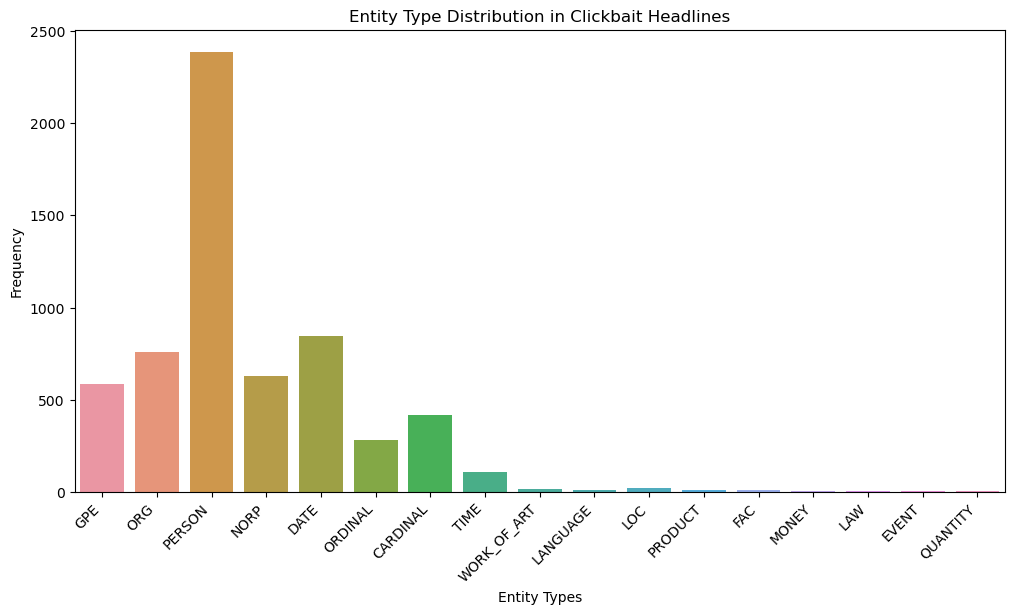

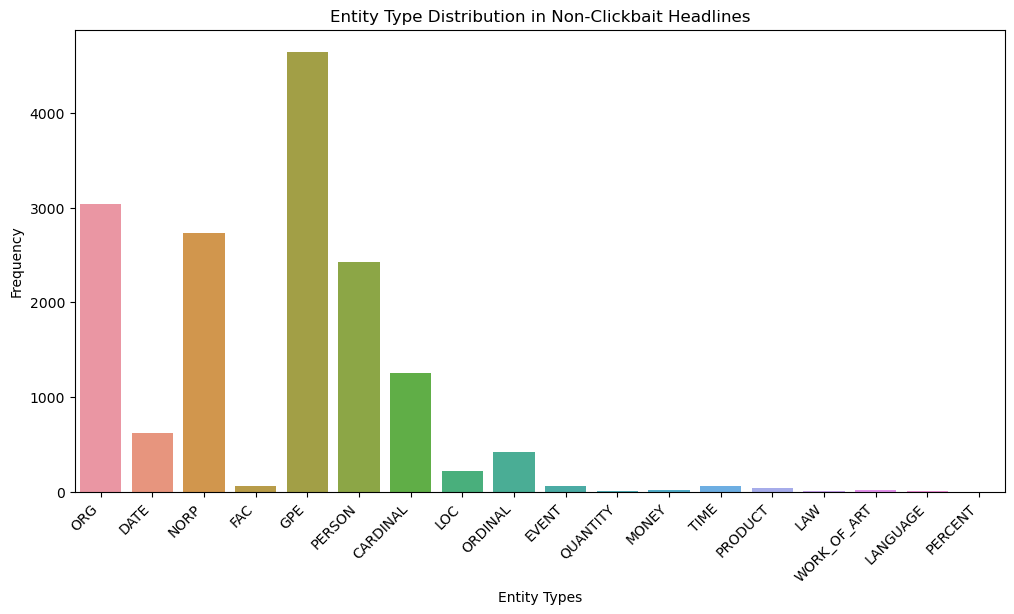

In [41]:
# Function to extract and count entity types using spaCy
def extract_entity_types(dataframe,label):
    
    entity_types_counter = Counter()
    # Drop rows with missing 'headline'
    dataframe = dataframe.dropna(subset=['all_cleaned'])
    dataframe = dataframe[dataframe['label']==label]['all_cleaned']

    # Process each headline using spaCy NER
    for headline in dataframe:
        doc = nlp(headline)
        entity_types = [ent.label_ for ent in doc.ents]  # Extract the entity type
        entity_types_counter.update(entity_types)

    return entity_types_counter

# Extract entity types for clickbait and non-clickbait headlines
entity_types_clickbait = extract_entity_types(data,1)
entity_types_nonclickbait = extract_entity_types(data,0)

# Plot bar graphs for the distribution of entity types
def plot_entity_type_distribution(entity_types_counter, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(entity_types_counter.keys()), y=list(entity_types_counter.values()))
    plt.title(title)
    plt.xlabel('Entity Types')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

# Plot entity type distribution for clickbait headlines
plot_entity_type_distribution(entity_types_clickbait, 'Entity Type Distribution in Clickbait Headlines')

# Plot entity type distribution for non-clickbait headlines
plot_entity_type_distribution(entity_types_nonclickbait, 'Entity Type Distribution in Non-Clickbait Headlines')

In [42]:
# Function to check if the 'headlines' column contains a GPE entity
def contains_gpe(headline):
    doc = nlp(headline)
    return any(ent.label_ == 'GPE' for ent in doc.ents)

# Apply the function to create a new column 'contains_gpe'
train_data['contains_gpe'] = train_data['headline'].apply(contains_gpe)

# Display the updated DataFrame
print(train_data)

                                                headline  label  contains_gpe
0                                     Should I Get Bings      1         False
1          Which TV Female Friend Group Do You Belong In      1         False
2      The New "Star Wars: The Force Awakens" Trailer...      1         False
3      This Vine Of New York On "Celebrity Big Brothe...      1         False
4      A Couple Did A Stunning Photo Shoot With Their...      1         False
...                                                  ...    ...           ...
31995  To Make Female Hearts Flutter in Iraq, Throw a...      0          True
31996  British Liberal Democrat Patsy Calton, 56, die...      0         False
31997  Drone smartphone app to help heart attack vict...      0         False
31998  Netanyahu Urges Pope Benedict, in Israel, to D...      0          True
31999  Computer Makers Prepare to Stake Bigger Claim ...      0         False

[32000 rows x 3 columns]


In [43]:
train_data['sentiment'] = sentiment
train_data['contains_numbers'] = contains_numbers
train_data['contains_personal_pronouns'] = contains_personal_pronouns
train_data

headline  label  contains_gpe  \
0                                     Should I Get Bings      1         False   
1          Which TV Female Friend Group Do You Belong In      1         False   
2      The New "Star Wars: The Force Awakens" Trailer...      1         False   
3      This Vine Of New York On "Celebrity Big Brothe...      1         False   
4      A Couple Did A Stunning Photo Shoot With Their...      1         False   
...                                                  ...    ...           ...   
31995  To Make Female Hearts Flutter in Iraq, Throw a...      0          True   
31996  British Liberal Democrat Patsy Calton, 56, die...      0         False   
31997  Drone smartphone app to help heart attack vict...      0         False   
31998  Netanyahu Urges Pope Benedict, in Israel, to D...      0          True   
31999  Computer Makers Prepare to Stake Bigger Claim ...      0         False   

       sentiment  contains_numbers  contains_personal_pronouns  
0         0.0000             False                       False  
1         0.4939             False                        True  
2        -0.5574             False                        True  
3         0.6115             False                       False  
4        -0.3400             False                       False  
...          ...               ...                         ...  
31995     0.0000             False                       False  
31996    -0.6597              True                       False  
31997    -0.4019             False                       False  
31998    -0.3400             False                       False  
31999     0.0000             False                       False  

[32000 rows x 6 columns]

In [44]:
column_order = [col for col in train_data.columns if col != 'label'] + ['label']
train_data = train_data[column_order]

In [45]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column
train_data['contains_gpe'] = label_encoder.fit_transform(train_data['contains_gpe'])
train_data['contains_numbers'] = label_encoder.fit_transform(train_data['contains_numbers'])
train_data['contains_personal_pronouns'] = label_encoder.fit_transform(train_data['contains_personal_pronouns'])


# Display the updated DataFrame
print(train_data)

                                                headline  contains_gpe  \
0                                     Should I Get Bings             0   
1          Which TV Female Friend Group Do You Belong In             0   
2      The New "Star Wars: The Force Awakens" Trailer...             0   
3      This Vine Of New York On "Celebrity Big Brothe...             0   
4      A Couple Did A Stunning Photo Shoot With Their...             0   
...                                                  ...           ...   
31995  To Make Female Hearts Flutter in Iraq, Throw a...             1   
31996  British Liberal Democrat Patsy Calton, 56, die...             0   
31997  Drone smartphone app to help heart attack vict...             0   
31998  Netanyahu Urges Pope Benedict, in Israel, to D...             1   
31999  Computer Makers Prepare to Stake Bigger Claim ...             0   

       sentiment  contains_numbers  contains_personal_pronouns  label  
0         0.0000                 0     

In [46]:
train_data.to_csv('output.csv', index=False)

Analyzing the lingustic relationships between clickbait and non-clickbait headlines helped us gather some potential insights based on general characteristics of clickbait/non-clickbait headlines:

1. **Action-Oriented Language (Verbs):**
   - Clickbait headlines might use more action-oriented verbs to create a sense of urgency or excitement.
   - Non-clickbait headlines may focus on conveying information without necessarily emphasizing action.

2. **Sensational Adjectives (Adjectival Modifiers):**
   - Clickbait headlines may employ more sensational adjectives to evoke emotions and grab attention.
   - Non-clickbait headlines might use adjectives more neutrally or informatively.

3. **Personalization (Pronouns and Named Entities):**
   - Clickbait headlines might use more personal pronouns and named entities to create a sense of relevance to the reader.
   - Non-clickbait headlines may have a more neutral tone and use pronouns less frequently.

4. **Descriptive Language (Adverbs and Adjectives):**
   - Clickbait headlines may employ more descriptive language, including adverbs and adjectives, to paint a vivid picture.
   - Non-clickbait headlines might focus on delivering information succinctly without relying heavily on descriptive elements.

6. **Sentiment:**
   - Clickbait headlines might exhibit a more emotional tone, aiming to trigger emotional responses from readers.
   - Non-clickbait headlines may maintain a more objective and factual tone.
   
- Punctuation marks like exclamation points or question marks showed no significant correlation with clickbait labels.
- Linguistic features, specifically the prevalence of personal pronouns and the presence of numerical characters, were identified as key indicators of clickbait headlines.
- Correlation heatmap analysis highlighted strong associations between clickbait labels and three linguistic features: 'contains_personal_pronouns', 'contains_numbers', and 'sentiment'.
- The heatmap and countplots suggested these features play a crucial role in distinguishing clickbait content.
- Entity type analysis demonstrated that non-clickbait headlines often focus on factual information, with a notable emphasis on the geopolitical entity type.
- The inclusion of the 'geo_political_entity' feature was deemed valuable for providing additional insights into distinction between clickbait and non-clickbait classes.
- Overall, the EDA findings provide a nuanced understanding of linguistic characteristics like 'contains_numbers','contains_personal_pronouns','contains_gpe' and 'sentiment' contributed to clickbait identification, laying the groundwork for the development of a robust clickbait/non-clickbait detection model.